# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=65,
        fold=1,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_17-31-59/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191567 [00:00<?, ?it/s]

  0%|          | 0/21461 [00:00<?, ?it/s]

  0%|          | 0/53624 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191567 [00:00<?, ?it/s]

  0%|          | 0/53624 [00:00<?, ?it/s]

  0%|          | 0/21461 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.5389 | MulticlassF1Score=0.0694
Batch-30 : CrossEntropyLoss=2.4861 | MulticlassF1Score=0.1645
Batch-45 : CrossEntropyLoss=2.4815 | MulticlassF1Score=0.2005
Batch-60 : CrossEntropyLoss=2.4229 | MulticlassF1Score=0.2453
Batch-75 : CrossEntropyLoss=2.4077 | MulticlassF1Score=0.2911
Batch-90 : CrossEntropyLoss=2.3848 | MulticlassF1Score=0.3213
Batch-105: CrossEntropyLoss=2.4442 | MulticlassF1Score=0.3452
Batch-120: CrossEntropyLoss=2.3884 | MulticlassF1Score=0.3702
Batch-135: CrossEntropyLoss=2.3628 | MulticlassF1Score=0.3946
Batch-150: CrossEntropyLoss=2.3744 | MulticlassF1Score=0.4206
Batch-165: CrossEntropyLoss=2.3537 | MulticlassF1Score=0.4426
Batch-180: CrossEntropyLoss=2.3531 | MulticlassF1Score=0.4608
Batch-195: CrossEntropyLoss=2.3425 | MulticlassF1Score=0.4778
Batch-210: CrossEntropyLoss=2.3390 | MulticlassF1Score=0.4919
Batch-225: CrossEntropyLoss=2.3263 | MulticlassF1Score=0.5042
Batch-226: CrossEntropyLoss=2.3372 | MulticlassF1Score=0.5048

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3417 | MulticlassF1Score=0.6696
Batch-30 : CrossEntropyLoss=2.3607 | MulticlassF1Score=0.6722
Batch-45 : CrossEntropyLoss=2.3622 | MulticlassF1Score=0.6713
Batch-60 : CrossEntropyLoss=2.3670 | MulticlassF1Score=0.6742
Batch-63 : CrossEntropyLoss=2.3434 | MulticlassF1Score=0.6734

Training   : Mean CrossEntropyLoss = 2.4105 | Mean MulticlassF1Score = 0.3330
Validation : Mean CrossEntropyLoss = 2.3501 | Mean MulticlassF1Score = 0.6708

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3440 | MulticlassF1Score=0.6811
Batch-30 : CrossEntropyLoss=2.3500 | MulticlassF1Score=0.6765
Batch-45 : CrossEntropyLoss=2.3552 | MulticlassF1Score=0.6762
Batch-60 : CrossEntropyLoss=2.3521 | MulticlassF1Score=0.6787
Batch-75 : CrossEntropyLoss=2.3534 | MulticlassF1Score=0.6777
Batch-90 : CrossEntropyLoss=2.3527 | MulticlassF1Score=0.6776
Batch-105: CrossEntropyLoss=2.3224 | MulticlassF1Score=0.6821
Batch-120: CrossEntropyLoss=2.3201 | MulticlassF1Score=0.6920
Batch-135: CrossEntropyLoss=2.3055 | MulticlassF1Score=0.6997
Batch-150: CrossEntropyLoss=2.3077 | MulticlassF1Score=0.7073
Batch-165: CrossEntropyLoss=2.3240 | MulticlassF1Score=0.7149
Batch-180: CrossEntropyLoss=2.3194 | MulticlassF1Score=0.7214
Batch-195: CrossEntropyLoss=2.3067 | MulticlassF1Score=0.7271
Batch-210: CrossEntropyLoss=2.3166 | MulticlassF1Score=0.7320
Batch-225: CrossEntropyLoss=2.3023 | MulticlassF1Score=0.7363
Batch-226: CrossEntropyLoss=2.3151 | MulticlassF1Score=0.7365

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3141 | MulticlassF1Score=0.7937
Batch-30 : CrossEntropyLoss=2.3182 | MulticlassF1Score=0.7980
Batch-45 : CrossEntropyLoss=2.3241 | MulticlassF1Score=0.7997
Batch-60 : CrossEntropyLoss=2.3096 | MulticlassF1Score=0.8003
Batch-63 : CrossEntropyLoss=2.3047 | MulticlassF1Score=0.8015

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3301 | Mean MulticlassF1Score = 0.6971
Validation : Mean CrossEntropyLoss = 2.3103 | Mean MulticlassF1Score = 0.7971

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3245 | MulticlassF1Score=0.7921
Batch-30 : CrossEntropyLoss=2.3178 | MulticlassF1Score=0.7964
Batch-45 : CrossEntropyLoss=2.2989 | MulticlassF1Score=0.7977
Batch-60 : CrossEntropyLoss=2.3022 | MulticlassF1Score=0.7991
Batch-75 : CrossEntropyLoss=2.3100 | MulticlassF1Score=0.8006
Batch-90 : CrossEntropyLoss=2.3177 | MulticlassF1Score=0.8016
Batch-105: CrossEntropyLoss=2.3093 | MulticlassF1Score=0.8018
Batch-120: CrossEntropyLoss=2.3045 | MulticlassF1Score=0.8016
Batch-135: CrossEntropyLoss=2.3093 | MulticlassF1Score=0.8019
Batch-150: CrossEntropyLoss=2.3065 | MulticlassF1Score=0.8020
Batch-165: CrossEntropyLoss=2.3199 | MulticlassF1Score=0.8022
Batch-180: CrossEntropyLoss=2.2992 | MulticlassF1Score=0.8023
Batch-195: CrossEntropyLoss=2.3185 | MulticlassF1Score=0.8028
Batch-210: CrossEntropyLoss=2.3023 | MulticlassF1Score=0.8035
Batch-225: CrossEntropyLoss=2.3052 | MulticlassF1Score=0.8039
Batch-226: CrossEntropyLoss=2.3095 | MulticlassF1Score=0.8039

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3247 | MulticlassF1Score=0.7978
Batch-30 : CrossEntropyLoss=2.3041 | MulticlassF1Score=0.8048
Batch-45 : CrossEntropyLoss=2.3112 | MulticlassF1Score=0.8052
Batch-60 : CrossEntropyLoss=2.3025 | MulticlassF1Score=0.8042
Batch-63 : CrossEntropyLoss=2.3016 | MulticlassF1Score=0.8049

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3088 | Mean MulticlassF1Score = 0.8008
Validation : Mean CrossEntropyLoss = 2.3089 | Mean MulticlassF1Score = 0.8026

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3122 | MulticlassF1Score=0.8074
Batch-30 : CrossEntropyLoss=2.3034 | MulticlassF1Score=0.8060
Batch-45 : CrossEntropyLoss=2.3107 | MulticlassF1Score=0.8076
Batch-60 : CrossEntropyLoss=2.3026 | MulticlassF1Score=0.8092
Batch-75 : CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8092
Batch-90 : CrossEntropyLoss=2.3159 | MulticlassF1Score=0.8077
Batch-105: CrossEntropyLoss=2.3055 | MulticlassF1Score=0.8076
Batch-120: CrossEntropyLoss=2.3081 | MulticlassF1Score=0.8072
Batch-135: CrossEntropyLoss=2.3084 | MulticlassF1Score=0.8071
Batch-150: CrossEntropyLoss=2.3053 | MulticlassF1Score=0.8073
Batch-165: CrossEntropyLoss=2.3154 | MulticlassF1Score=0.8066
Batch-180: CrossEntropyLoss=2.2986 | MulticlassF1Score=0.8077
Batch-195: CrossEntropyLoss=2.3006 | MulticlassF1Score=0.8092
Batch-210: CrossEntropyLoss=2.2932 | MulticlassF1Score=0.8103
Batch-225: CrossEntropyLoss=2.3019 | MulticlassF1Score=0.8118
Batch-226: CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8120

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8251
Batch-30 : CrossEntropyLoss=2.3013 | MulticlassF1Score=0.8234
Batch-45 : CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8249
Batch-60 : CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8260
Batch-63 : CrossEntropyLoss=2.3010 | MulticlassF1Score=0.8257

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3060 | Mean MulticlassF1Score = 0.8083
Validation : Mean CrossEntropyLoss = 2.3021 | Mean MulticlassF1Score = 0.8264

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8270
Batch-30 : CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8285
Batch-45 : CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8280
Batch-60 : CrossEntropyLoss=2.3016 | MulticlassF1Score=0.8293
Batch-75 : CrossEntropyLoss=2.2983 | MulticlassF1Score=0.8297
Batch-90 : CrossEntropyLoss=2.3023 | MulticlassF1Score=0.8296
Batch-105: CrossEntropyLoss=2.2932 | MulticlassF1Score=0.8296
Batch-120: CrossEntropyLoss=2.2994 | MulticlassF1Score=0.8293
Batch-135: CrossEntropyLoss=2.3026 | MulticlassF1Score=0.8294
Batch-150: CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8294
Batch-165: CrossEntropyLoss=2.3069 | MulticlassF1Score=0.8297
Batch-180: CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8306
Batch-195: CrossEntropyLoss=2.3031 | MulticlassF1Score=0.8301
Batch-210: CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8299
Batch-225: CrossEntropyLoss=2.3055 | MulticlassF1Score=0.8299
Batch-226: CrossEntropyLoss=2.3152 | MulticlassF1Score=0.8298

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8240
Batch-30 : CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8271
Batch-45 : CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8289
Batch-60 : CrossEntropyLoss=2.3051 | MulticlassF1Score=0.8281
Batch-63 : CrossEntropyLoss=2.2974 | MulticlassF1Score=0.8275

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3005 | Mean MulticlassF1Score = 0.8295
Validation : Mean CrossEntropyLoss = 2.3015 | Mean MulticlassF1Score = 0.8273

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2978 | MulticlassF1Score=0.8316
Batch-30 : CrossEntropyLoss=2.2894 | MulticlassF1Score=0.8341
Batch-45 : CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8351
Batch-60 : CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8341
Batch-75 : CrossEntropyLoss=2.3029 | MulticlassF1Score=0.8320
Batch-90 : CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8314
Batch-105: CrossEntropyLoss=2.3044 | MulticlassF1Score=0.8316
Batch-120: CrossEntropyLoss=2.2997 | MulticlassF1Score=0.8324
Batch-135: CrossEntropyLoss=2.3079 | MulticlassF1Score=0.8317
Batch-150: CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8325
Batch-165: CrossEntropyLoss=2.2979 | MulticlassF1Score=0.8322
Batch-180: CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8325
Batch-195: CrossEntropyLoss=2.3049 | MulticlassF1Score=0.8322
Batch-210: CrossEntropyLoss=2.2985 | MulticlassF1Score=0.8320
Batch-225: CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8322
Batch-226: CrossEntropyLoss=2.3020 | MulticlassF1Score=0.8321

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3100 | MulticlassF1Score=0.8329
Batch-30 : CrossEntropyLoss=2.3114 | MulticlassF1Score=0.8281
Batch-45 : CrossEntropyLoss=2.3055 | MulticlassF1Score=0.8262
Batch-60 : CrossEntropyLoss=2.3012 | MulticlassF1Score=0.8278
Batch-63 : CrossEntropyLoss=2.2986 | MulticlassF1Score=0.8279

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2996 | Mean MulticlassF1Score = 0.8326
Validation : Mean CrossEntropyLoss = 2.3013 | Mean MulticlassF1Score = 0.8305

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3020 | MulticlassF1Score=0.8332
Batch-30 : CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8326
Batch-45 : CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8316
Batch-60 : CrossEntropyLoss=2.3063 | MulticlassF1Score=0.8320
Batch-75 : CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8323
Batch-90 : CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8322
Batch-105: CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8329
Batch-120: CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8329
Batch-135: CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8331
Batch-150: CrossEntropyLoss=2.3040 | MulticlassF1Score=0.8332
Batch-165: CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8332
Batch-180: CrossEntropyLoss=2.2909 | MulticlassF1Score=0.8331
Batch-195: CrossEntropyLoss=2.2978 | MulticlassF1Score=0.8332
Batch-210: CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8333
Batch-225: CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8334
Batch-226: CrossEntropyLoss=2.2958 | MulticlassF1Score=0.8335

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3050 | MulticlassF1Score=0.8258
Batch-30 : CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8285
Batch-45 : CrossEntropyLoss=2.3087 | MulticlassF1Score=0.8300
Batch-60 : CrossEntropyLoss=2.3107 | MulticlassF1Score=0.8293
Batch-63 : CrossEntropyLoss=2.3063 | MulticlassF1Score=0.8289

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2991 | Mean MulticlassF1Score = 0.8327
Validation : Mean CrossEntropyLoss = 2.3010 | Mean MulticlassF1Score = 0.8282

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2993 | MulticlassF1Score=0.8370
Batch-30 : CrossEntropyLoss=2.3043 | MulticlassF1Score=0.8353
Batch-45 : CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8361
Batch-60 : CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8365
Batch-75 : CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8366
Batch-90 : CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8357
Batch-105: CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8355
Batch-120: CrossEntropyLoss=2.3023 | MulticlassF1Score=0.8351
Batch-135: CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8349
Batch-150: CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8349
Batch-165: CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8354
Batch-180: CrossEntropyLoss=2.2894 | MulticlassF1Score=0.8354
Batch-195: CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8355
Batch-210: CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8355
Batch-225: CrossEntropyLoss=2.3031 | MulticlassF1Score=0.8350
Batch-226: CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8350

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3020 | MulticlassF1Score=0.8254
Batch-30 : CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8264
Batch-45 : CrossEntropyLoss=2.2987 | MulticlassF1Score=0.8295
Batch-60 : CrossEntropyLoss=2.3048 | MulticlassF1Score=0.8295
Batch-63 : CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8299

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2986 | Mean MulticlassF1Score = 0.8361
Validation : Mean CrossEntropyLoss = 2.3005 | Mean MulticlassF1Score = 0.8280

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8367
Batch-30 : CrossEntropyLoss=2.2996 | MulticlassF1Score=0.8404
Batch-45 : CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8434
Batch-60 : CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8451
Batch-75 : CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8461
Batch-90 : CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8469
Batch-105: CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8473
Batch-120: CrossEntropyLoss=2.2980 | MulticlassF1Score=0.8485
Batch-135: CrossEntropyLoss=2.3002 | MulticlassF1Score=0.8490
Batch-150: CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8504
Batch-165: CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8511
Batch-180: CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8519
Batch-195: CrossEntropyLoss=2.2914 | MulticlassF1Score=0.8521
Batch-210: CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8527
Batch-225: CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8533
Batch-226: CrossEntropyLoss=2.3025 | MulticlassF1Score=0.8533

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8527
Batch-30 : CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8531
Batch-45 : CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8528
Batch-60 : CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8526
Batch-63 : CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8528

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2932 | Mean MulticlassF1Score = 0.8476
Validation : Mean CrossEntropyLoss = 2.2937 | Mean MulticlassF1Score = 0.8526

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8650
Batch-30 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8633
Batch-45 : CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8642
Batch-60 : CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8631
Batch-75 : CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8642
Batch-90 : CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8637
Batch-105: CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8638
Batch-120: CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8632
Batch-135: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8631
Batch-150: CrossEntropyLoss=2.3013 | MulticlassF1Score=0.8622
Batch-165: CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8618
Batch-180: CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8619
Batch-195: CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8621
Batch-210: CrossEntropyLoss=2.2992 | MulticlassF1Score=0.8620
Batch-225: CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8617
Batch-226: CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8617

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8510
Batch-30 : CrossEntropyLoss=2.2943 | MulticlassF1Score=0.8549
Batch-45 : CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8551
Batch-60 : CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8538
Batch-63 : CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8546

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2905 | Mean MulticlassF1Score = 0.8629
Validation : Mean CrossEntropyLoss = 2.2930 | Mean MulticlassF1Score = 0.8533

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8669
Batch-30 : CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8651
Batch-45 : CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8655
Batch-60 : CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8626
Batch-75 : CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8633
Batch-90 : CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8632
Batch-105: CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8640
Batch-120: CrossEntropyLoss=2.2761 | MulticlassF1Score=0.8665
Batch-135: CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8684
Batch-150: CrossEntropyLoss=2.2782 | MulticlassF1Score=0.8703
Batch-165: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8716
Batch-180: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8731
Batch-195: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.8739
Batch-210: CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8751
Batch-225: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8765
Batch-226: CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8766

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8819
Batch-30 : CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8824
Batch-45 : CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8832
Batch-60 : CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8838
Batch-63 : CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8838

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2860 | Mean MulticlassF1Score = 0.8680
Validation : Mean CrossEntropyLoss = 2.2841 | Mean MulticlassF1Score = 0.8833

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8936
Batch-30 : CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8941
Batch-45 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.8941
Batch-60 : CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8931
Batch-75 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.8925
Batch-90 : CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8920
Batch-105: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.8924
Batch-120: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8925
Batch-135: CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8926
Batch-150: CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8921
Batch-165: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8924
Batch-180: CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8919
Batch-195: CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8920
Batch-210: CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8919
Batch-225: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8921
Batch-226: CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8921

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8873
Batch-30 : CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8867
Batch-45 : CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8863
Batch-60 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8865
Batch-63 : CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8861

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2812 | Mean MulticlassF1Score = 0.8928
Validation : Mean CrossEntropyLoss = 2.2833 | Mean MulticlassF1Score = 0.8861

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8962
Batch-30 : CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8928
Batch-45 : CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8932
Batch-60 : CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8943
Batch-75 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8943
Batch-90 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8945
Batch-105: CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8944
Batch-120: CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8945
Batch-135: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8951
Batch-150: CrossEntropyLoss=2.2897 | MulticlassF1Score=0.8949
Batch-165: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.8950
Batch-180: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8948
Batch-195: CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8950
Batch-210: CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8947
Batch-225: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.8947
Batch-226: CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8947

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8864
Batch-30 : CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8873
Batch-45 : CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8867
Batch-60 : CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8864
Batch-63 : CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8862

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2803 | Mean MulticlassF1Score = 0.8945
Validation : Mean CrossEntropyLoss = 2.2832 | Mean MulticlassF1Score = 0.8860

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.8927
Batch-30 : CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8942
Batch-45 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8954
Batch-60 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.8968
Batch-75 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8971
Batch-90 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.8965
Batch-105: CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8967
Batch-120: CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8961
Batch-135: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8960
Batch-150: CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8963
Batch-165: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.8963
Batch-180: CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8963
Batch-195: CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8963
Batch-210: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8964
Batch-225: CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8965
Batch-226: CrossEntropyLoss=2.2752 | MulticlassF1Score=0.8966

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8896
Batch-30 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8880
Batch-45 : CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8875
Batch-60 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8869
Batch-63 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8870

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2797 | Mean MulticlassF1Score = 0.8958
Validation : Mean CrossEntropyLoss = 2.2829 | Mean MulticlassF1Score = 0.8872

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9034
Batch-30 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9021
Batch-45 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9003
Batch-60 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8990
Batch-75 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8999
Batch-90 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8997
Batch-105: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.9002
Batch-120: CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8997
Batch-135: CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8992
Batch-150: CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8989
Batch-165: CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8984
Batch-180: CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8984
Batch-195: CrossEntropyLoss=2.2763 | MulticlassF1Score=0.8984
Batch-210: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.8982
Batch-225: CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8980
Batch-226: CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8980

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8921
Batch-30 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8890
Batch-45 : CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8893
Batch-60 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8879
Batch-63 : CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8876

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2791 | Mean MulticlassF1Score = 0.8999
Validation : Mean CrossEntropyLoss = 2.2828 | Mean MulticlassF1Score = 0.8905

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.8991
Batch-30 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9010
Batch-45 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9002
Batch-60 : CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8995
Batch-75 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.8983
Batch-90 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8988
Batch-105: CrossEntropyLoss=2.2768 | MulticlassF1Score=0.8982
Batch-120: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.8982
Batch-135: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8984
Batch-150: CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8992
Batch-165: CrossEntropyLoss=2.2749 | MulticlassF1Score=0.8997
Batch-180: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8997
Batch-195: CrossEntropyLoss=2.2761 | MulticlassF1Score=0.8996
Batch-210: CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8994
Batch-225: CrossEntropyLoss=2.2757 | MulticlassF1Score=0.8993
Batch-226: CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8993

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8886
Batch-30 : CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8870
Batch-45 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8883
Batch-60 : CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8870
Batch-63 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8872

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2787 | Mean MulticlassF1Score = 0.8992
Validation : Mean CrossEntropyLoss = 2.2828 | Mean MulticlassF1Score = 0.8888

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.8998
Batch-30 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8979
Batch-45 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8981
Batch-60 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.8988
Batch-75 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.8984
Batch-90 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8991
Batch-105: CrossEntropyLoss=2.2761 | MulticlassF1Score=0.8995
Batch-120: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8996
Batch-135: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8997
Batch-150: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9001
Batch-165: CrossEntropyLoss=2.2806 | MulticlassF1Score=0.9001
Batch-180: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8999
Batch-195: CrossEntropyLoss=2.2791 | MulticlassF1Score=0.9001
Batch-210: CrossEntropyLoss=2.2802 | MulticlassF1Score=0.9002
Batch-225: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9003
Batch-226: CrossEntropyLoss=2.2788 | MulticlassF1Score=0.9003

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.8897
Batch-30 : CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8881
Batch-45 : CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8882
Batch-60 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8877
Batch-63 : CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8877

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2784 | Mean MulticlassF1Score = 0.8993
Validation : Mean CrossEntropyLoss = 2.2826 | Mean MulticlassF1Score = 0.8891

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8935
Batch-30 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9001
Batch-45 : CrossEntropyLoss=2.2836 | MulticlassF1Score=0.9014
Batch-60 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9011
Batch-75 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.9009
Batch-90 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9022
Batch-105: CrossEntropyLoss=2.2813 | MulticlassF1Score=0.9018
Batch-120: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9021
Batch-135: CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9018
Batch-150: CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9015
Batch-165: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9013
Batch-180: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.9013
Batch-195: CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9012
Batch-210: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9009
Batch-225: CrossEntropyLoss=2.2813 | MulticlassF1Score=0.9010
Batch-226: CrossEntropyLoss=2.2805 | MulticlassF1Score=0.9010

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8904
Batch-30 : CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8877
Batch-45 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8884
Batch-60 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8881
Batch-63 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8881

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2781 | Mean MulticlassF1Score = 0.9005
Validation : Mean CrossEntropyLoss = 2.2824 | Mean MulticlassF1Score = 0.8880

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.8974
Batch-30 : CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8980
Batch-45 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.9006
Batch-60 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.9009
Batch-75 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.9010
Batch-90 : CrossEntropyLoss=2.2862 | MulticlassF1Score=0.9008
Batch-105: CrossEntropyLoss=2.2839 | MulticlassF1Score=0.9014
Batch-120: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.9013
Batch-135: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9015
Batch-150: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9021
Batch-165: CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9022
Batch-180: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9020
Batch-195: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.9017
Batch-210: CrossEntropyLoss=2.2826 | MulticlassF1Score=0.9011
Batch-225: CrossEntropyLoss=2.2829 | MulticlassF1Score=0.9014
Batch-226: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9014

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8939
Batch-30 : CrossEntropyLoss=2.2909 | MulticlassF1Score=0.8877
Batch-45 : CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8902
Batch-60 : CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8891
Batch-63 : CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8884

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2780 | Mean MulticlassF1Score = 0.9004
Validation : Mean CrossEntropyLoss = 2.2824 | Mean MulticlassF1Score = 0.8902

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2827 | MulticlassF1Score=0.9062
Batch-30 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9028
Batch-45 : CrossEntropyLoss=2.2827 | MulticlassF1Score=0.9015
Batch-60 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9020
Batch-75 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.9023
Batch-90 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9027
Batch-105: CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9021
Batch-120: CrossEntropyLoss=2.2804 | MulticlassF1Score=0.9023
Batch-135: CrossEntropyLoss=2.2850 | MulticlassF1Score=0.9021
Batch-150: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9025
Batch-165: CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9021
Batch-180: CrossEntropyLoss=2.2804 | MulticlassF1Score=0.9019
Batch-195: CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9019
Batch-210: CrossEntropyLoss=2.2788 | MulticlassF1Score=0.9020
Batch-225: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9021
Batch-226: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9022

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8918
Batch-30 : CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8918
Batch-45 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.8907
Batch-60 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8910
Batch-63 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8909

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2777 | Mean MulticlassF1Score = 0.9023
Validation : Mean CrossEntropyLoss = 2.2816 | Mean MulticlassF1Score = 0.8908

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9056
Batch-30 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.9054
Batch-45 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9050
Batch-60 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9040
Batch-75 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9042
Batch-90 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9050
Batch-105: CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9058
Batch-120: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9061
Batch-135: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9061
Batch-150: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9066
Batch-165: CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9063
Batch-180: CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9064
Batch-195: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9062
Batch-210: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.9060
Batch-225: CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9058
Batch-226: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9058

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8863
Batch-30 : CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8913
Batch-45 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.8918
Batch-60 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8923
Batch-63 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.8927

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2767 | Mean MulticlassF1Score = 0.9062
Validation : Mean CrossEntropyLoss = 2.2809 | Mean MulticlassF1Score = 0.8899

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9060
Batch-30 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9072
Batch-45 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9064
Batch-60 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9060
Batch-75 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9058
Batch-90 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9063
Batch-105: CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9063
Batch-120: CrossEntropyLoss=2.2804 | MulticlassF1Score=0.9062
Batch-135: CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9064
Batch-150: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9068
Batch-165: CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9071
Batch-180: CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9074
Batch-195: CrossEntropyLoss=2.2815 | MulticlassF1Score=0.9073
Batch-210: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9075
Batch-225: CrossEntropyLoss=2.2788 | MulticlassF1Score=0.9077
Batch-226: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.9077

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8932
Batch-30 : CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8932
Batch-45 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8933
Batch-60 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8922
Batch-63 : CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8920

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2760 | Mean MulticlassF1Score = 0.9065
Validation : Mean CrossEntropyLoss = 2.2812 | Mean MulticlassF1Score = 0.8944

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.9061
Batch-30 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9092
Batch-45 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.9088
Batch-60 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9088
Batch-75 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9092
Batch-90 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9100
Batch-105: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9132
Batch-120: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9153
Batch-135: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9172
Batch-150: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9187
Batch-165: CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9199
Batch-180: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9209
Batch-195: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9219
Batch-210: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9225
Batch-225: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9234
Batch-226: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9234

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9198
Batch-30 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9216
Batch-45 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9207
Batch-60 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9215
Batch-63 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9214

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2713 | Mean MulticlassF1Score = 0.9147
Validation : Mean CrossEntropyLoss = 2.2723 | Mean MulticlassF1Score = 0.9196

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9367
Batch-30 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9375
Batch-45 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9377
Batch-60 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9377
Batch-75 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9381
Batch-90 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9380
Batch-105: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9381
Batch-120: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9374
Batch-135: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9374
Batch-150: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9372
Batch-165: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9372
Batch-180: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9371
Batch-195: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9372
Batch-210: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9373
Batch-225: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9371
Batch-226: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9372

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9214
Batch-30 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9238
Batch-45 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9230
Batch-60 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9221
Batch-63 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9221

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2670 | Mean MulticlassF1Score = 0.9374
Validation : Mean CrossEntropyLoss = 2.2720 | Mean MulticlassF1Score = 0.9221

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9360
Batch-30 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9376
Batch-45 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9371
Batch-60 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9382
Batch-75 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9379
Batch-90 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9387
Batch-105: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9390
Batch-120: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9383
Batch-135: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9384
Batch-150: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9385
Batch-165: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9384
Batch-180: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9383
Batch-195: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9384
Batch-210: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9384
Batch-225: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9381
Batch-226: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9381

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.9201
Batch-30 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9227
Batch-45 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9227
Batch-60 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9226
Batch-63 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9226

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2666 | Mean MulticlassF1Score = 0.9377
Validation : Mean CrossEntropyLoss = 2.2717 | Mean MulticlassF1Score = 0.9230

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9414
Batch-30 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9403
Batch-45 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9395
Batch-60 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9388
Batch-75 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9390
Batch-90 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9397
Batch-105: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9399
Batch-120: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9399
Batch-135: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9401
Batch-150: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9396
Batch-165: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9391
Batch-180: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9391
Batch-195: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9391
Batch-210: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9391
Batch-225: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9390
Batch-226: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9390

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9215
Batch-30 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9220
Batch-45 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9237
Batch-60 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9225
Batch-63 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9224

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2663 | Mean MulticlassF1Score = 0.9396
Validation : Mean CrossEntropyLoss = 2.2717 | Mean MulticlassF1Score = 0.9230

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9386
Batch-30 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9387
Batch-45 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9379
Batch-60 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9381
Batch-75 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9384
Batch-90 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9392
Batch-105: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9396
Batch-120: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9393
Batch-135: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9391
Batch-150: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9394
Batch-165: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9394
Batch-180: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9393
Batch-195: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9394
Batch-210: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9392
Batch-225: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9393
Batch-226: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9393

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9219
Batch-30 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9220
Batch-45 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9231
Batch-60 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9226
Batch-63 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9224

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2662 | Mean MulticlassF1Score = 0.9390
Validation : Mean CrossEntropyLoss = 2.2717 | Mean MulticlassF1Score = 0.9225

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9361
Batch-30 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9379
Batch-45 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9389
Batch-60 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9402
Batch-75 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9400
Batch-90 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9403
Batch-105: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9403
Batch-120: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9401
Batch-135: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9402
Batch-150: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9406
Batch-165: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9401
Batch-180: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9398
Batch-195: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9397
Batch-210: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9396
Batch-225: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9396
Batch-226: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9396

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9237
Batch-30 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9227
Batch-45 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9227
Batch-60 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9224
Batch-63 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9223

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2661 | Mean MulticlassF1Score = 0.9396
Validation : Mean CrossEntropyLoss = 2.2718 | Mean MulticlassF1Score = 0.9239

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9422
Batch-30 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9391
Batch-45 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9392
Batch-60 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9398
Batch-75 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9392
Batch-90 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9396
Batch-105: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9395
Batch-120: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9400
Batch-135: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9398
Batch-150: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9398
Batch-165: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9397
Batch-180: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9397
Batch-195: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9396
Batch-210: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9398
Batch-225: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9399
Batch-226: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9399

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9195
Batch-30 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9223
Batch-45 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9230
Batch-60 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9231
Batch-63 : CrossEntropyLoss=2.2802 | MulticlassF1Score=0.9225

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2660 | Mean MulticlassF1Score = 0.9397
Validation : Mean CrossEntropyLoss = 2.2718 | Mean MulticlassF1Score = 0.9208

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9415
Batch-30 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9429
Batch-45 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9410
Batch-60 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9403
Batch-75 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9410
Batch-90 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9409
Batch-105: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9410
Batch-120: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9407
Batch-135: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9405
Batch-150: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9404
Batch-165: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9403
Batch-180: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9403
Batch-195: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9401
Batch-210: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9397
Batch-225: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9395
Batch-226: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9395

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9259
Batch-30 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9228
Batch-45 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9200
Batch-60 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9206
Batch-63 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9207

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2662 | Mean MulticlassF1Score = 0.9406
Validation : Mean CrossEntropyLoss = 2.2723 | Mean MulticlassF1Score = 0.9228
Patience = 1/50❗

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9408
Batch-30 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9389
Batch-45 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9397
Batch-60 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9404
Batch-75 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9402
Batch-90 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9408
Batch-105: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9403
Batch-120: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9402
Batch-135: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9399
Batch-150: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9399
Batch-165: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9399
Batch-180: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9399
Batch-195: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9400
Batch-210: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9397
Batch-225: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9397
Batch-226: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9396

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9235
Batch-30 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9243
Batch-45 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9249
Batch-60 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9250
Batch-63 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9253

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2662 | Mean MulticlassF1Score = 0.9401
Validation : Mean CrossEntropyLoss = 2.2708 | Mean MulticlassF1Score = 0.9245
Patience = 2/50❗

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9428
Batch-30 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9427
Batch-45 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9435
Batch-60 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9431
Batch-75 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9425
Batch-90 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9436
Batch-105: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9435
Batch-120: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9425
Batch-135: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9427
Batch-150: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9431
Batch-165: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9431
Batch-180: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9430
Batch-195: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9429
Batch-210: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9428
Batch-225: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9428
Batch-226: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9428

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9245
Batch-30 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9248
Batch-45 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9255
Batch-60 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9264
Batch-63 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9255

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9432
Validation : Mean CrossEntropyLoss = 2.2708 | Mean MulticlassF1Score = 0.9253

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9403
Batch-30 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9402
Batch-45 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9412
Batch-60 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9419
Batch-75 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9429
Batch-90 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9431
Batch-105: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9432
Batch-120: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9431
Batch-135: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9433
Batch-150: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9433
Batch-165: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9434
Batch-180: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9436
Batch-195: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9435
Batch-210: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9435
Batch-225: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9436
Batch-226: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9436

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9228
Batch-30 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9240
Batch-45 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9248
Batch-60 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9252
Batch-63 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9254

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9426
Validation : Mean CrossEntropyLoss = 2.2708 | Mean MulticlassF1Score = 0.9236

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9448
Batch-30 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9445
Batch-45 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9433
Batch-60 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9440
Batch-75 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9433
Batch-90 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9427
Batch-105: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9428
Batch-120: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9437
Batch-135: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9439
Batch-150: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9439
Batch-165: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9440
Batch-180: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9441
Batch-195: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9442
Batch-210: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9442
Batch-225: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9440
Batch-226: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9440

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9247
Batch-30 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9248
Batch-45 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9253
Batch-60 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9248
Batch-63 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9252

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9439
Validation : Mean CrossEntropyLoss = 2.2708 | Mean MulticlassF1Score = 0.9249

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9447
Batch-30 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9432
Batch-45 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9450
Batch-60 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9448
Batch-75 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9453
Batch-90 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9455
Batch-105: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9451
Batch-120: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9447
Batch-135: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9446
Batch-150: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9443
Batch-165: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9440
Batch-180: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9440
Batch-195: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9441
Batch-210: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9443
Batch-225: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9443
Batch-226: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9444

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9281
Batch-30 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9283
Batch-45 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9265
Batch-60 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9257
Batch-63 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9255

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2646 | Mean MulticlassF1Score = 0.9444
Validation : Mean CrossEntropyLoss = 2.2707 | Mean MulticlassF1Score = 0.9272

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9448
Batch-30 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9450
Batch-45 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9453
Batch-60 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9457
Batch-75 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9455
Batch-90 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9451
Batch-105: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9452
Batch-120: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9451
Batch-135: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9455
Batch-150: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9471
Batch-165: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9481
Batch-180: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9495
Batch-195: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9504
Batch-210: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9514
Batch-225: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9522
Batch-226: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9522

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9434
Batch-30 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9438
Batch-45 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9452
Batch-60 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9457
Batch-63 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9454

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2622 | Mean MulticlassF1Score = 0.9472
Validation : Mean CrossEntropyLoss = 2.2646 | Mean MulticlassF1Score = 0.9441

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9661
Batch-30 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9658
Batch-45 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9651
Batch-60 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9650
Batch-75 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9647
Batch-90 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9643
Batch-105: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9640
Batch-120: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9643
Batch-135: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9642
Batch-150: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9639
Batch-165: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9639
Batch-180: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9638
Batch-195: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9639
Batch-210: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9637
Batch-225: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9640
Batch-226: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9640

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9450
Batch-30 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9452
Batch-45 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9446
Batch-60 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9458
Batch-63 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9460

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2586 | Mean MulticlassF1Score = 0.9645
Validation : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9450

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9620
Batch-30 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9626
Batch-45 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9636
Batch-60 : CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9641
Batch-75 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9640
Batch-90 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9639
Batch-105: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9641
Batch-120: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9643
Batch-135: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9644
Batch-150: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9642
Batch-165: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9641
Batch-180: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9640
Batch-195: CrossEntropyLoss=2.2528 | MulticlassF1Score=0.9642
Batch-210: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9642
Batch-225: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9644
Batch-226: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9644

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9497
Batch-30 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9458
Batch-45 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9449
Batch-60 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9454
Batch-63 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9454

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2584 | Mean MulticlassF1Score = 0.9640
Validation : Mean CrossEntropyLoss = 2.2646 | Mean MulticlassF1Score = 0.9478

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9641
Batch-30 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9653
Batch-45 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9654
Batch-60 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9651
Batch-75 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9652
Batch-90 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9649
Batch-105: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9645
Batch-120: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9643
Batch-135: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9645
Batch-150: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9646
Batch-165: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9646
Batch-180: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9648
Batch-195: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9649
Batch-210: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9647
Batch-225: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9645
Batch-226: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9645

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9442
Batch-30 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9451
Batch-45 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9455
Batch-60 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9454
Batch-63 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9453

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2584 | Mean MulticlassF1Score = 0.9648
Validation : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9444

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9633
Batch-30 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9643
Batch-45 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9635
Batch-60 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9637
Batch-75 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9642
Batch-90 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9645
Batch-105: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9645
Batch-120: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9644
Batch-135: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9646
Batch-150: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9647
Batch-165: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9643
Batch-180: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9643
Batch-195: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9641
Batch-210: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9640
Batch-225: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9645
Batch-226: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9645

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9487
Batch-30 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9469
Batch-45 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9472
Batch-60 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9475
Batch-63 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9471

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2585 | Mean MulticlassF1Score = 0.9640
Validation : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9471
Patience = 3/50❗

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9668
Batch-30 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9655
Batch-45 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9657
Batch-60 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9648
Batch-75 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9650
Batch-90 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9651
Batch-105: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9656
Batch-120: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9657
Batch-135: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9655
Batch-150: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9655
Batch-165: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9657
Batch-180: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9658
Batch-195: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9657
Batch-210: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9657
Batch-225: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9657
Batch-226: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9657

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9465
Batch-30 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9466
Batch-45 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9480
Batch-60 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9475
Batch-63 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9475

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2581 | Mean MulticlassF1Score = 0.9657
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9472

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9663
Batch-30 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9656
Batch-45 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9668
Batch-60 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9664
Batch-75 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9663
Batch-90 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9668
Batch-105: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9667
Batch-120: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9668
Batch-135: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9668
Batch-150: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9667
Batch-165: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9666
Batch-180: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9666
Batch-195: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9665
Batch-210: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9666
Batch-225: CrossEntropyLoss=2.2527 | MulticlassF1Score=0.9666
Batch-226: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9667

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9459
Batch-30 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9458
Batch-45 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9462
Batch-60 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9465
Batch-63 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9468

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2577 | Mean MulticlassF1Score = 0.9665
Validation : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9461

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9666
Batch-30 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9671
Batch-45 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9662
Batch-60 : CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9665
Batch-75 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9664
Batch-90 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9668
Batch-105: CrossEntropyLoss=2.2531 | MulticlassF1Score=0.9673
Batch-120: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9674
Batch-135: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9673
Batch-150: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9673
Batch-165: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9676
Batch-180: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9673
Batch-195: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9673
Batch-210: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9671
Batch-225: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9670
Batch-226: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9670

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9498
Batch-30 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9497
Batch-45 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9486
Batch-60 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9485
Batch-63 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9481

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2576 | Mean MulticlassF1Score = 0.9668
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9488

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9666
Batch-30 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9678
Batch-45 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9671
Batch-60 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9668
Batch-75 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9664
Batch-90 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9667
Batch-105: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9663
Batch-120: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9663
Batch-135: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9659
Batch-150: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9657
Batch-165: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9658
Batch-180: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9657
Batch-195: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9656
Batch-210: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9657
Batch-225: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9658
Batch-226: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9658

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9478
Batch-30 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9457
Batch-45 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9461
Batch-60 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9463
Batch-63 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9463

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2581 | Mean MulticlassF1Score = 0.9664
Validation : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9470
Patience = 4/50❗

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9648
Batch-30 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9680
Batch-45 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9665
Batch-60 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9667
Batch-75 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9666
Batch-90 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9665
Batch-105: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9666
Batch-120: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9667
Batch-135: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9668
Batch-150: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9672
Batch-165: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9671
Batch-180: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9672
Batch-195: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9670
Batch-210: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9668
Batch-225: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9668
Batch-226: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9668

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9484
Batch-30 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9481
Batch-45 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9478
Batch-60 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9473
Batch-63 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9476

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2578 | Mean MulticlassF1Score = 0.9666
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9484

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9677
Batch-30 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9674
Batch-45 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9676
Batch-60 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9671
Batch-75 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9671
Batch-90 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9673
Batch-105: CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9675
Batch-120: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9672
Batch-135: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9671
Batch-150: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9669
Batch-165: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9671
Batch-180: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9672
Batch-195: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9673
Batch-210: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9675
Batch-225: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9676
Batch-226: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9676

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9488
Batch-30 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9503
Batch-45 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9500
Batch-60 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9486
Batch-63 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9488

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2575 | Mean MulticlassF1Score = 0.9674
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9490

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9682
Batch-30 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9688
Batch-45 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9692
Batch-60 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9685
Batch-75 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9685
Batch-90 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9686
Batch-105: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9692
Batch-120: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9692
Batch-135: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9688
Batch-150: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9686
Batch-165: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9685
Batch-180: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9684
Batch-195: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9683
Batch-210: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9681
Batch-225: CrossEntropyLoss=2.2524 | MulticlassF1Score=0.9684
Batch-226: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9684

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9502
Batch-30 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9478
Batch-45 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9479
Batch-60 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9484
Batch-63 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9486

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2572 | Mean MulticlassF1Score = 0.9687
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9497

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9704
Batch-30 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9718
Batch-45 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9715
Batch-60 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9707
Batch-75 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9701
Batch-90 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9695
Batch-105: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9694
Batch-120: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9695
Batch-135: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9691
Batch-150: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9690
Batch-165: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9691
Batch-180: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9689
Batch-195: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9689
Batch-210: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9691
Batch-225: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9690
Batch-226: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9690

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9479
Batch-30 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9486
Batch-45 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9478
Batch-60 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9481
Batch-63 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9484

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9696
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9484

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9708
Batch-30 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9686
Batch-45 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9692
Batch-60 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9690
Batch-75 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9685
Batch-90 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9686
Batch-105: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9688
Batch-120: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9688
Batch-135: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9687
Batch-150: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9689
Batch-165: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9689
Batch-180: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9689
Batch-195: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9690
Batch-210: CrossEntropyLoss=2.2515 | MulticlassF1Score=0.9690
Batch-225: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9693
Batch-226: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9693

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9508
Batch-30 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9499
Batch-45 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9491
Batch-60 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9495
Batch-63 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9493

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2568 | Mean MulticlassF1Score = 0.9690
Validation : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9498

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9700
Batch-30 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9707
Batch-45 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9702
Batch-60 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9698
Batch-75 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9697
Batch-90 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9697
Batch-105: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9696
Batch-120: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9697
Batch-135: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9695
Batch-150: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9694
Batch-165: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9697
Batch-180: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9697
Batch-195: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9695
Batch-210: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9696
Batch-225: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9696
Batch-226: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9696

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9489
Batch-30 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9476
Batch-45 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9473
Batch-60 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9483
Batch-63 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9483

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2567 | Mean MulticlassF1Score = 0.9699
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9487

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2567
Best CrossEntropyLoss training    : 2.2636
Best MulticlassF1Score validation : 0.9699
Best MulticlassF1Score validation : 0.9487
Training duration                 : 2.3061 minutes.
Training date                     : 2022-10-19 11:38:01.481946+08:00


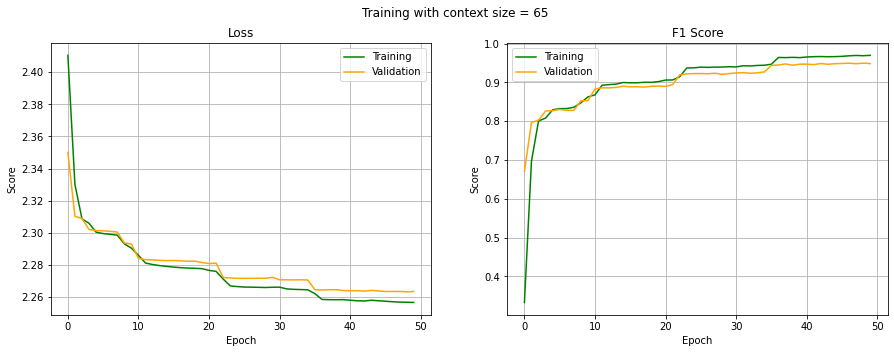

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9700, device='cuda:0'),
 tensor(0.9483, device='cuda:0'),
 tensor(0.9485, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9700, device='cuda:0'),
 tensor(0.9483, device='cuda:0'),
 tensor(0.9485, device='cuda:0'))

## Heatmap

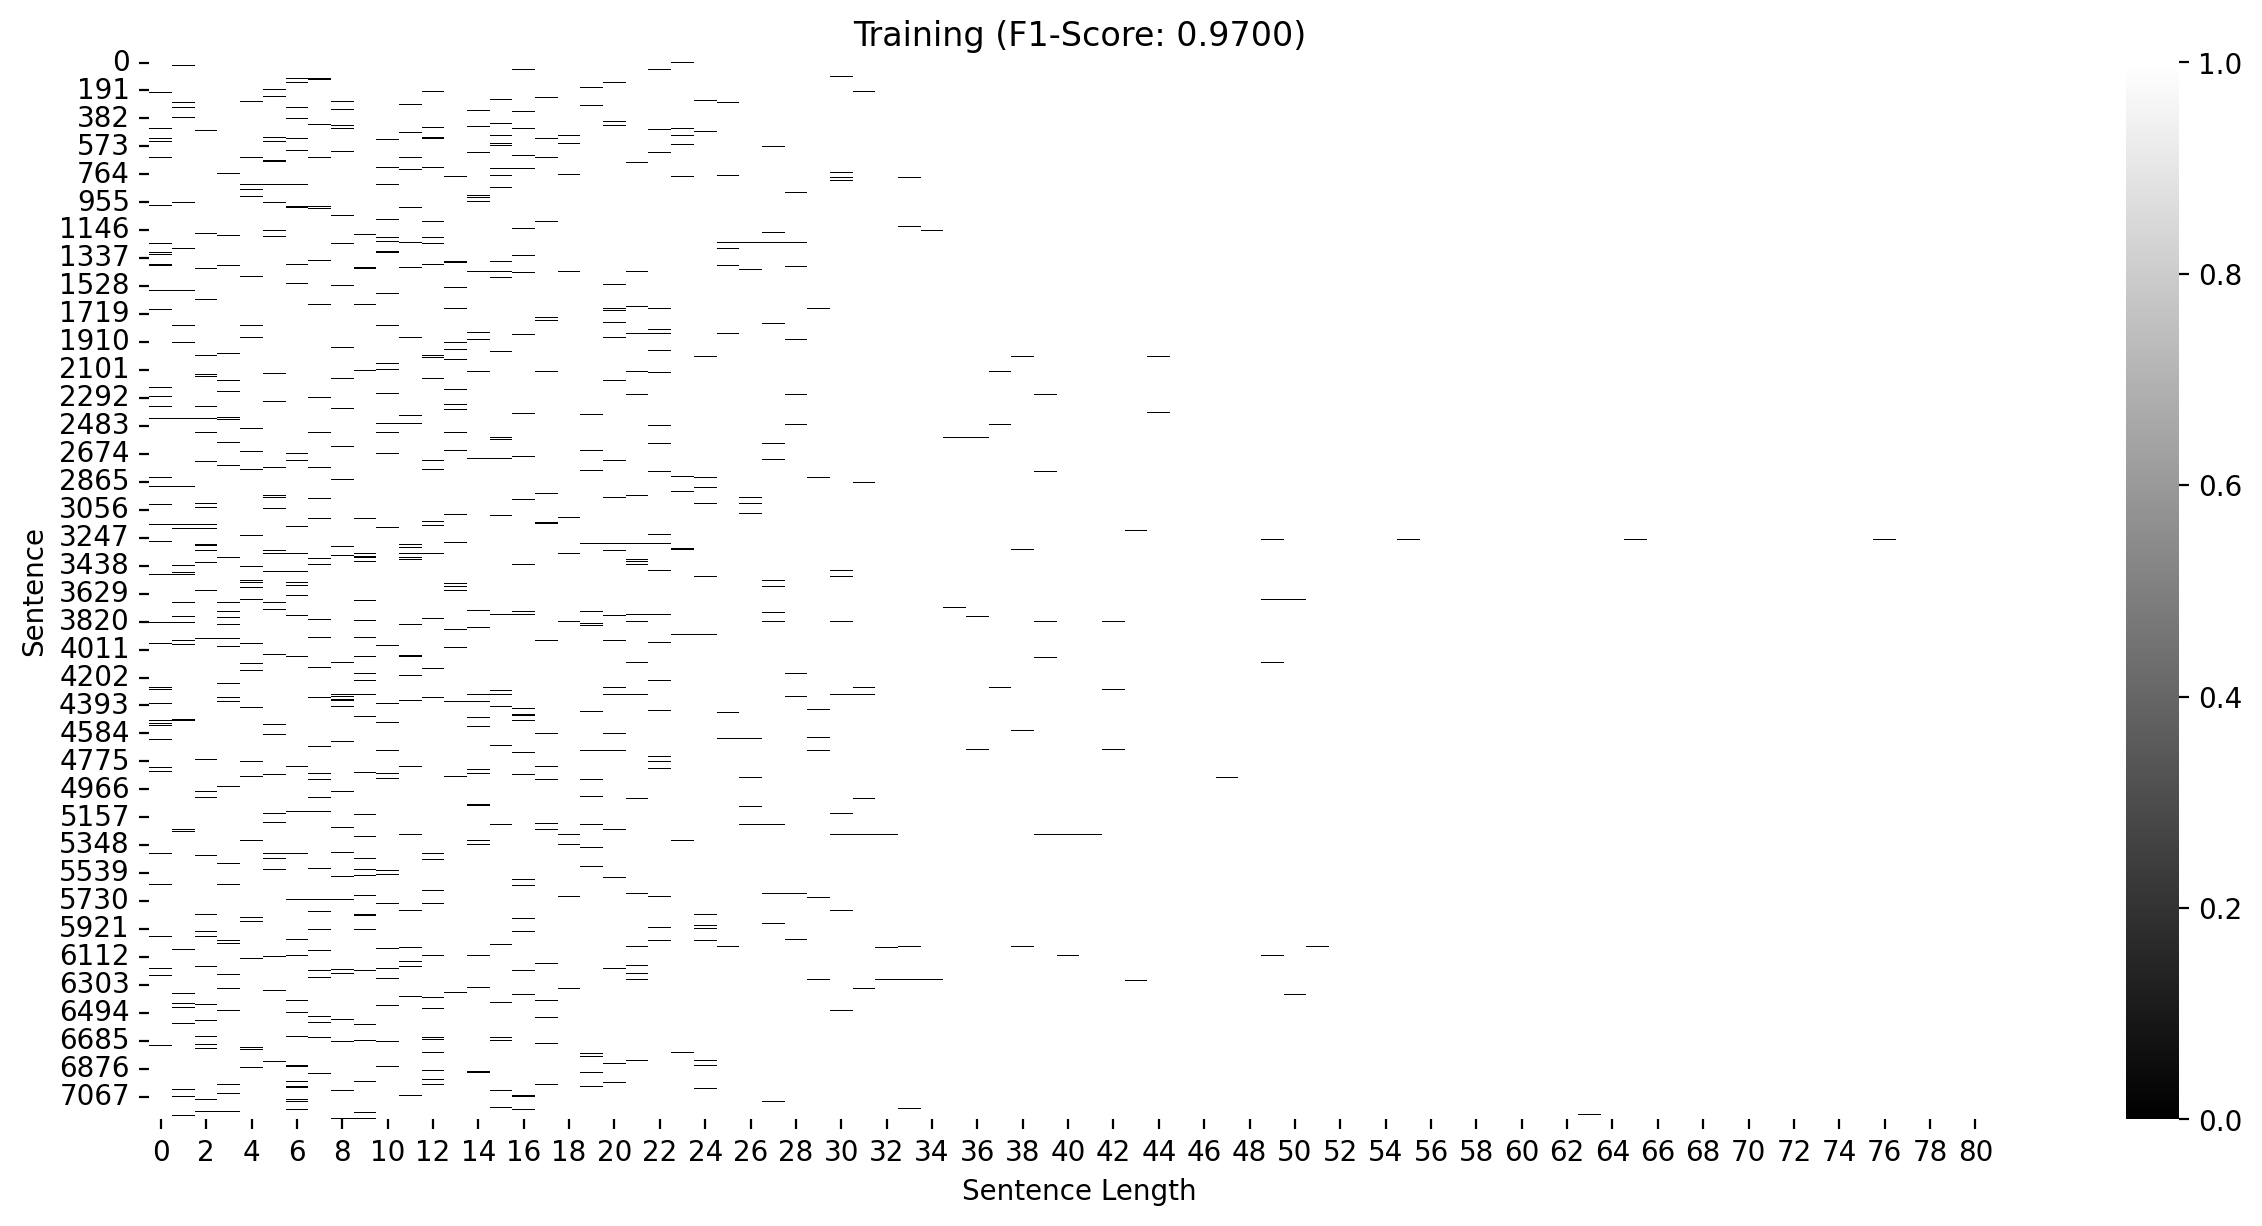

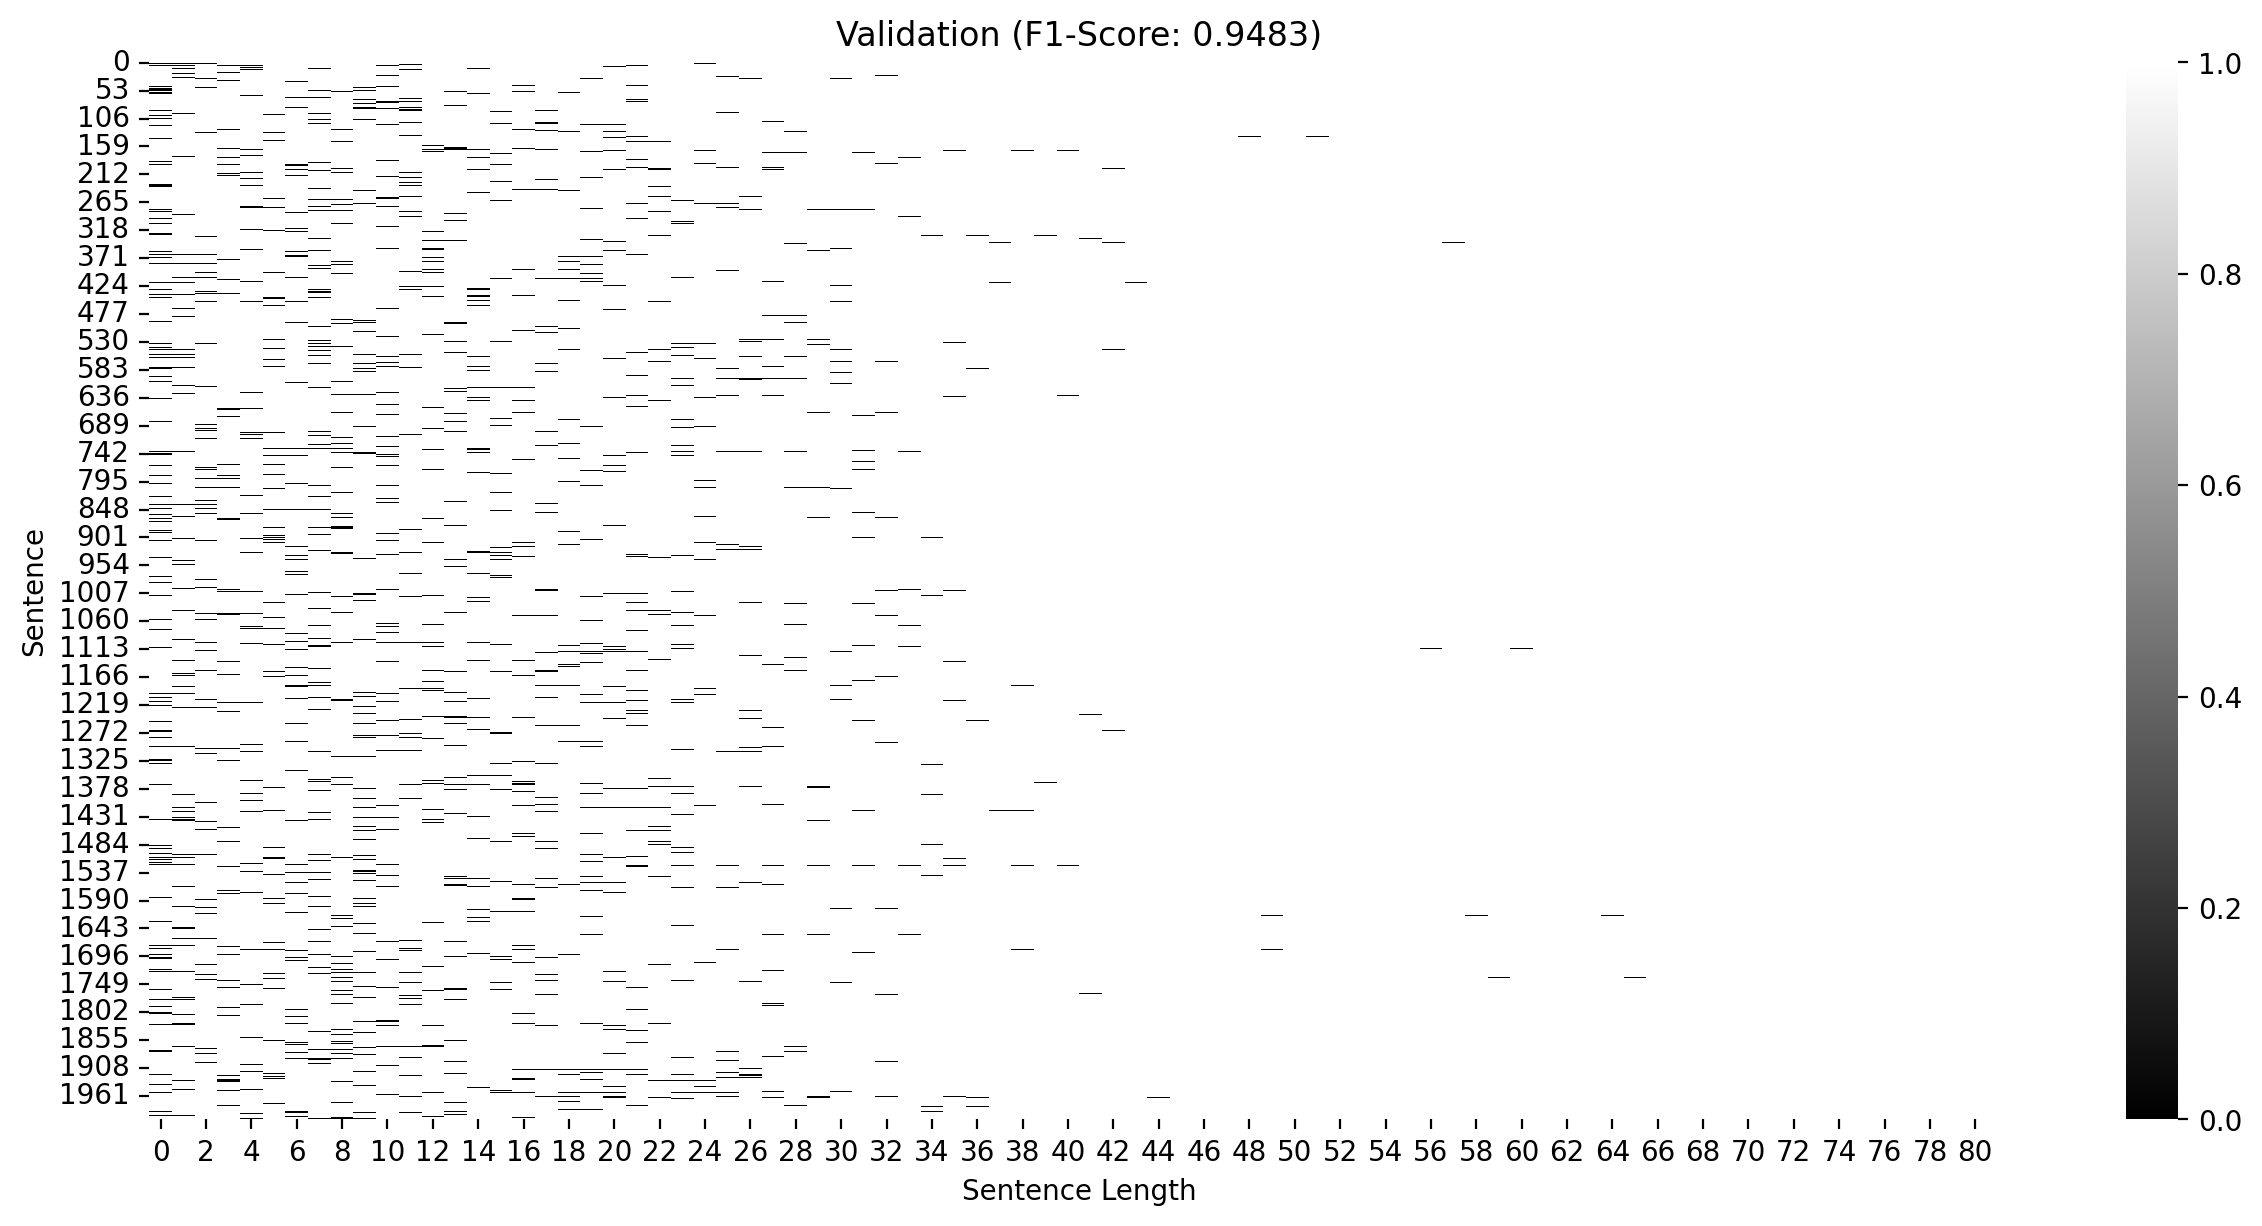

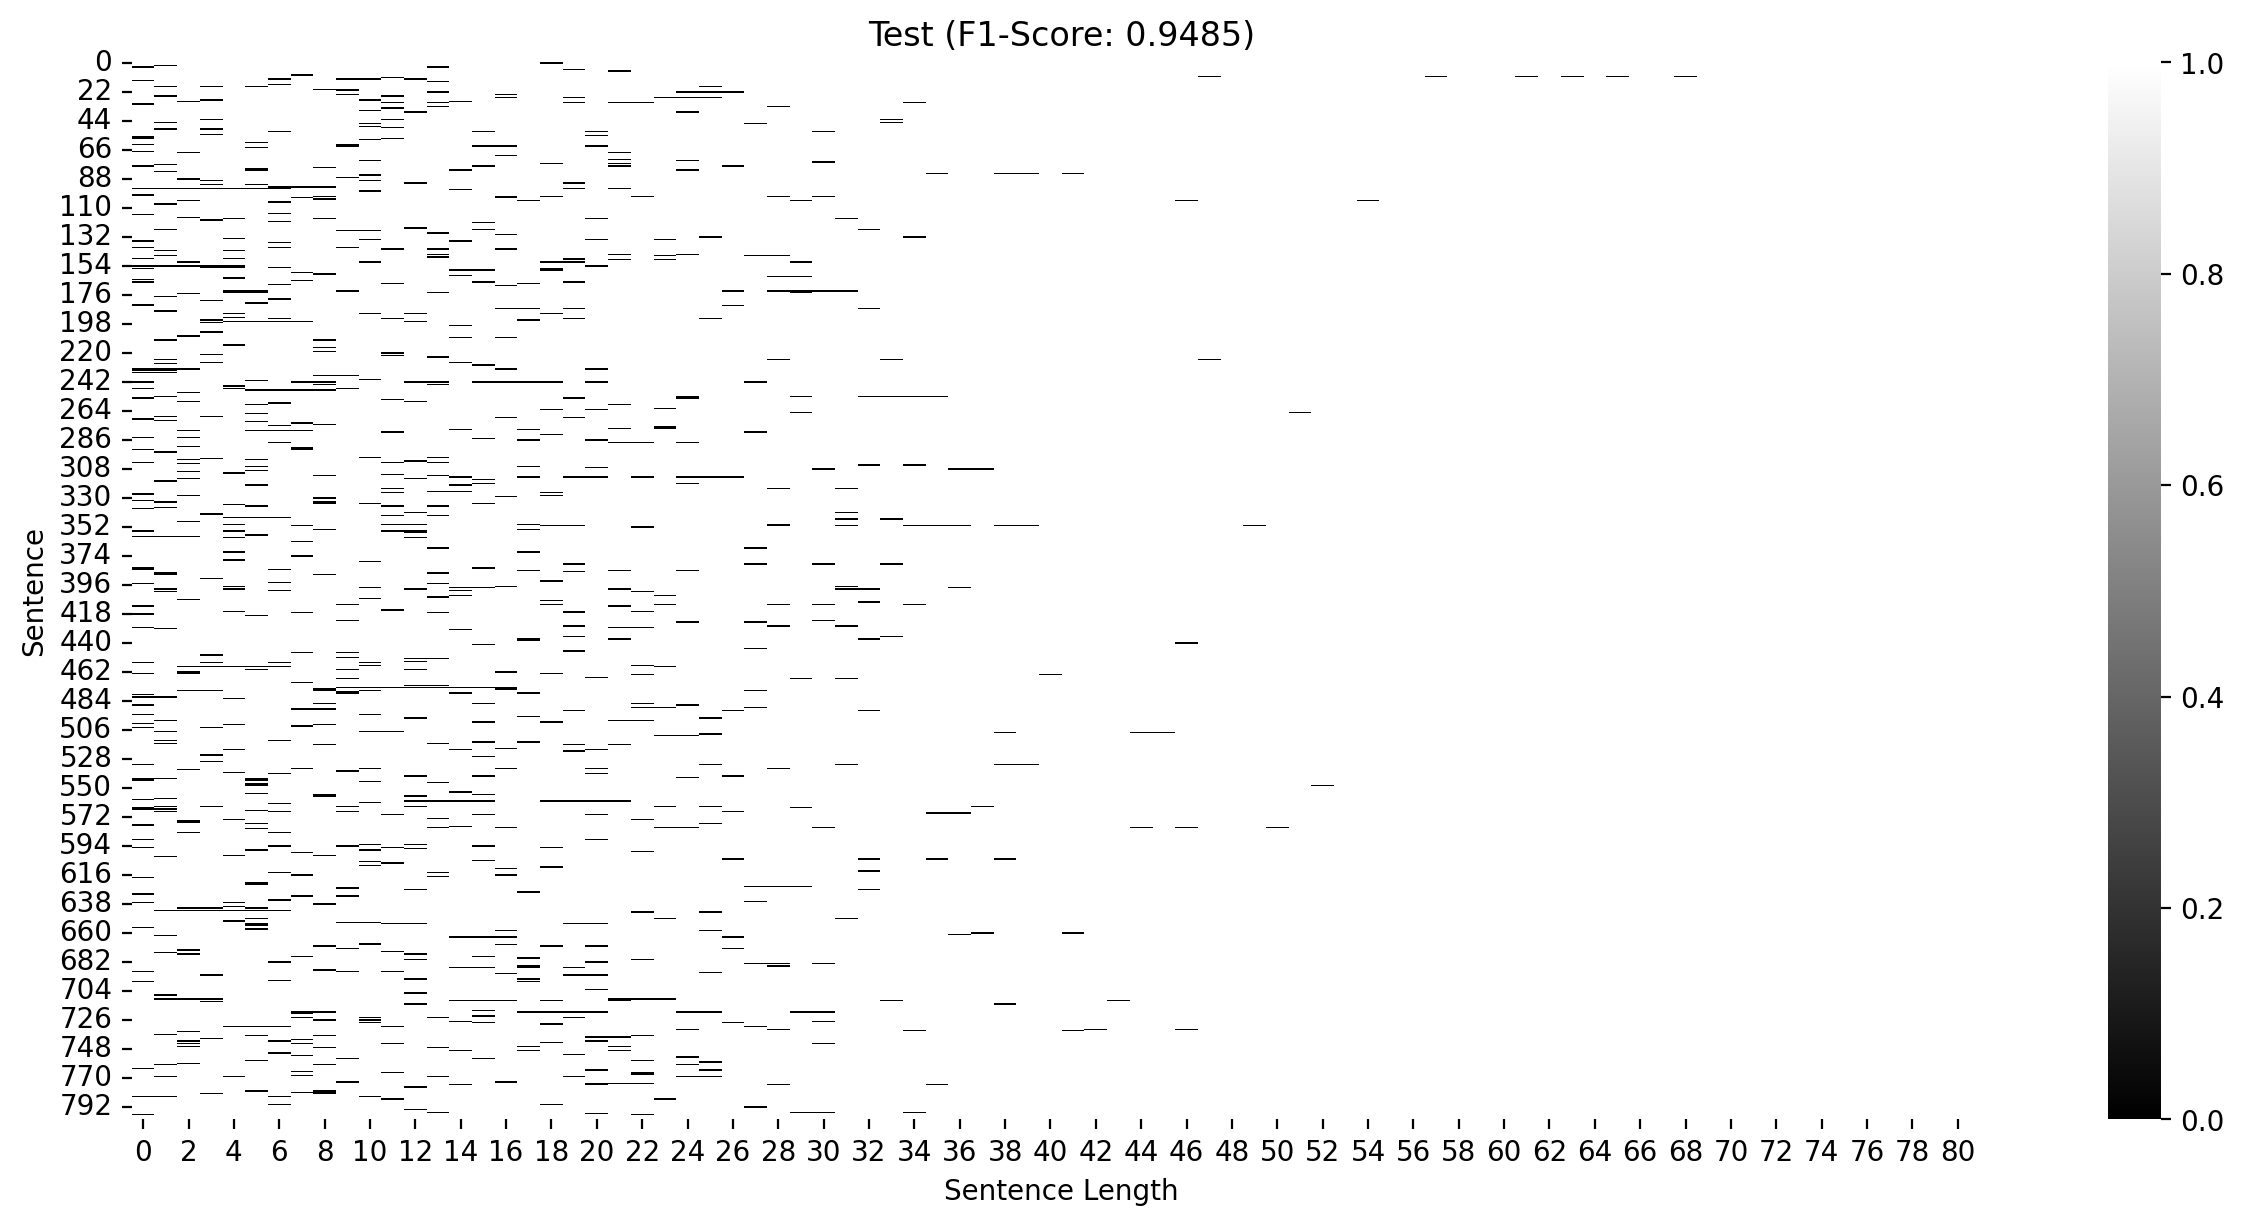

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 96 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 120 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


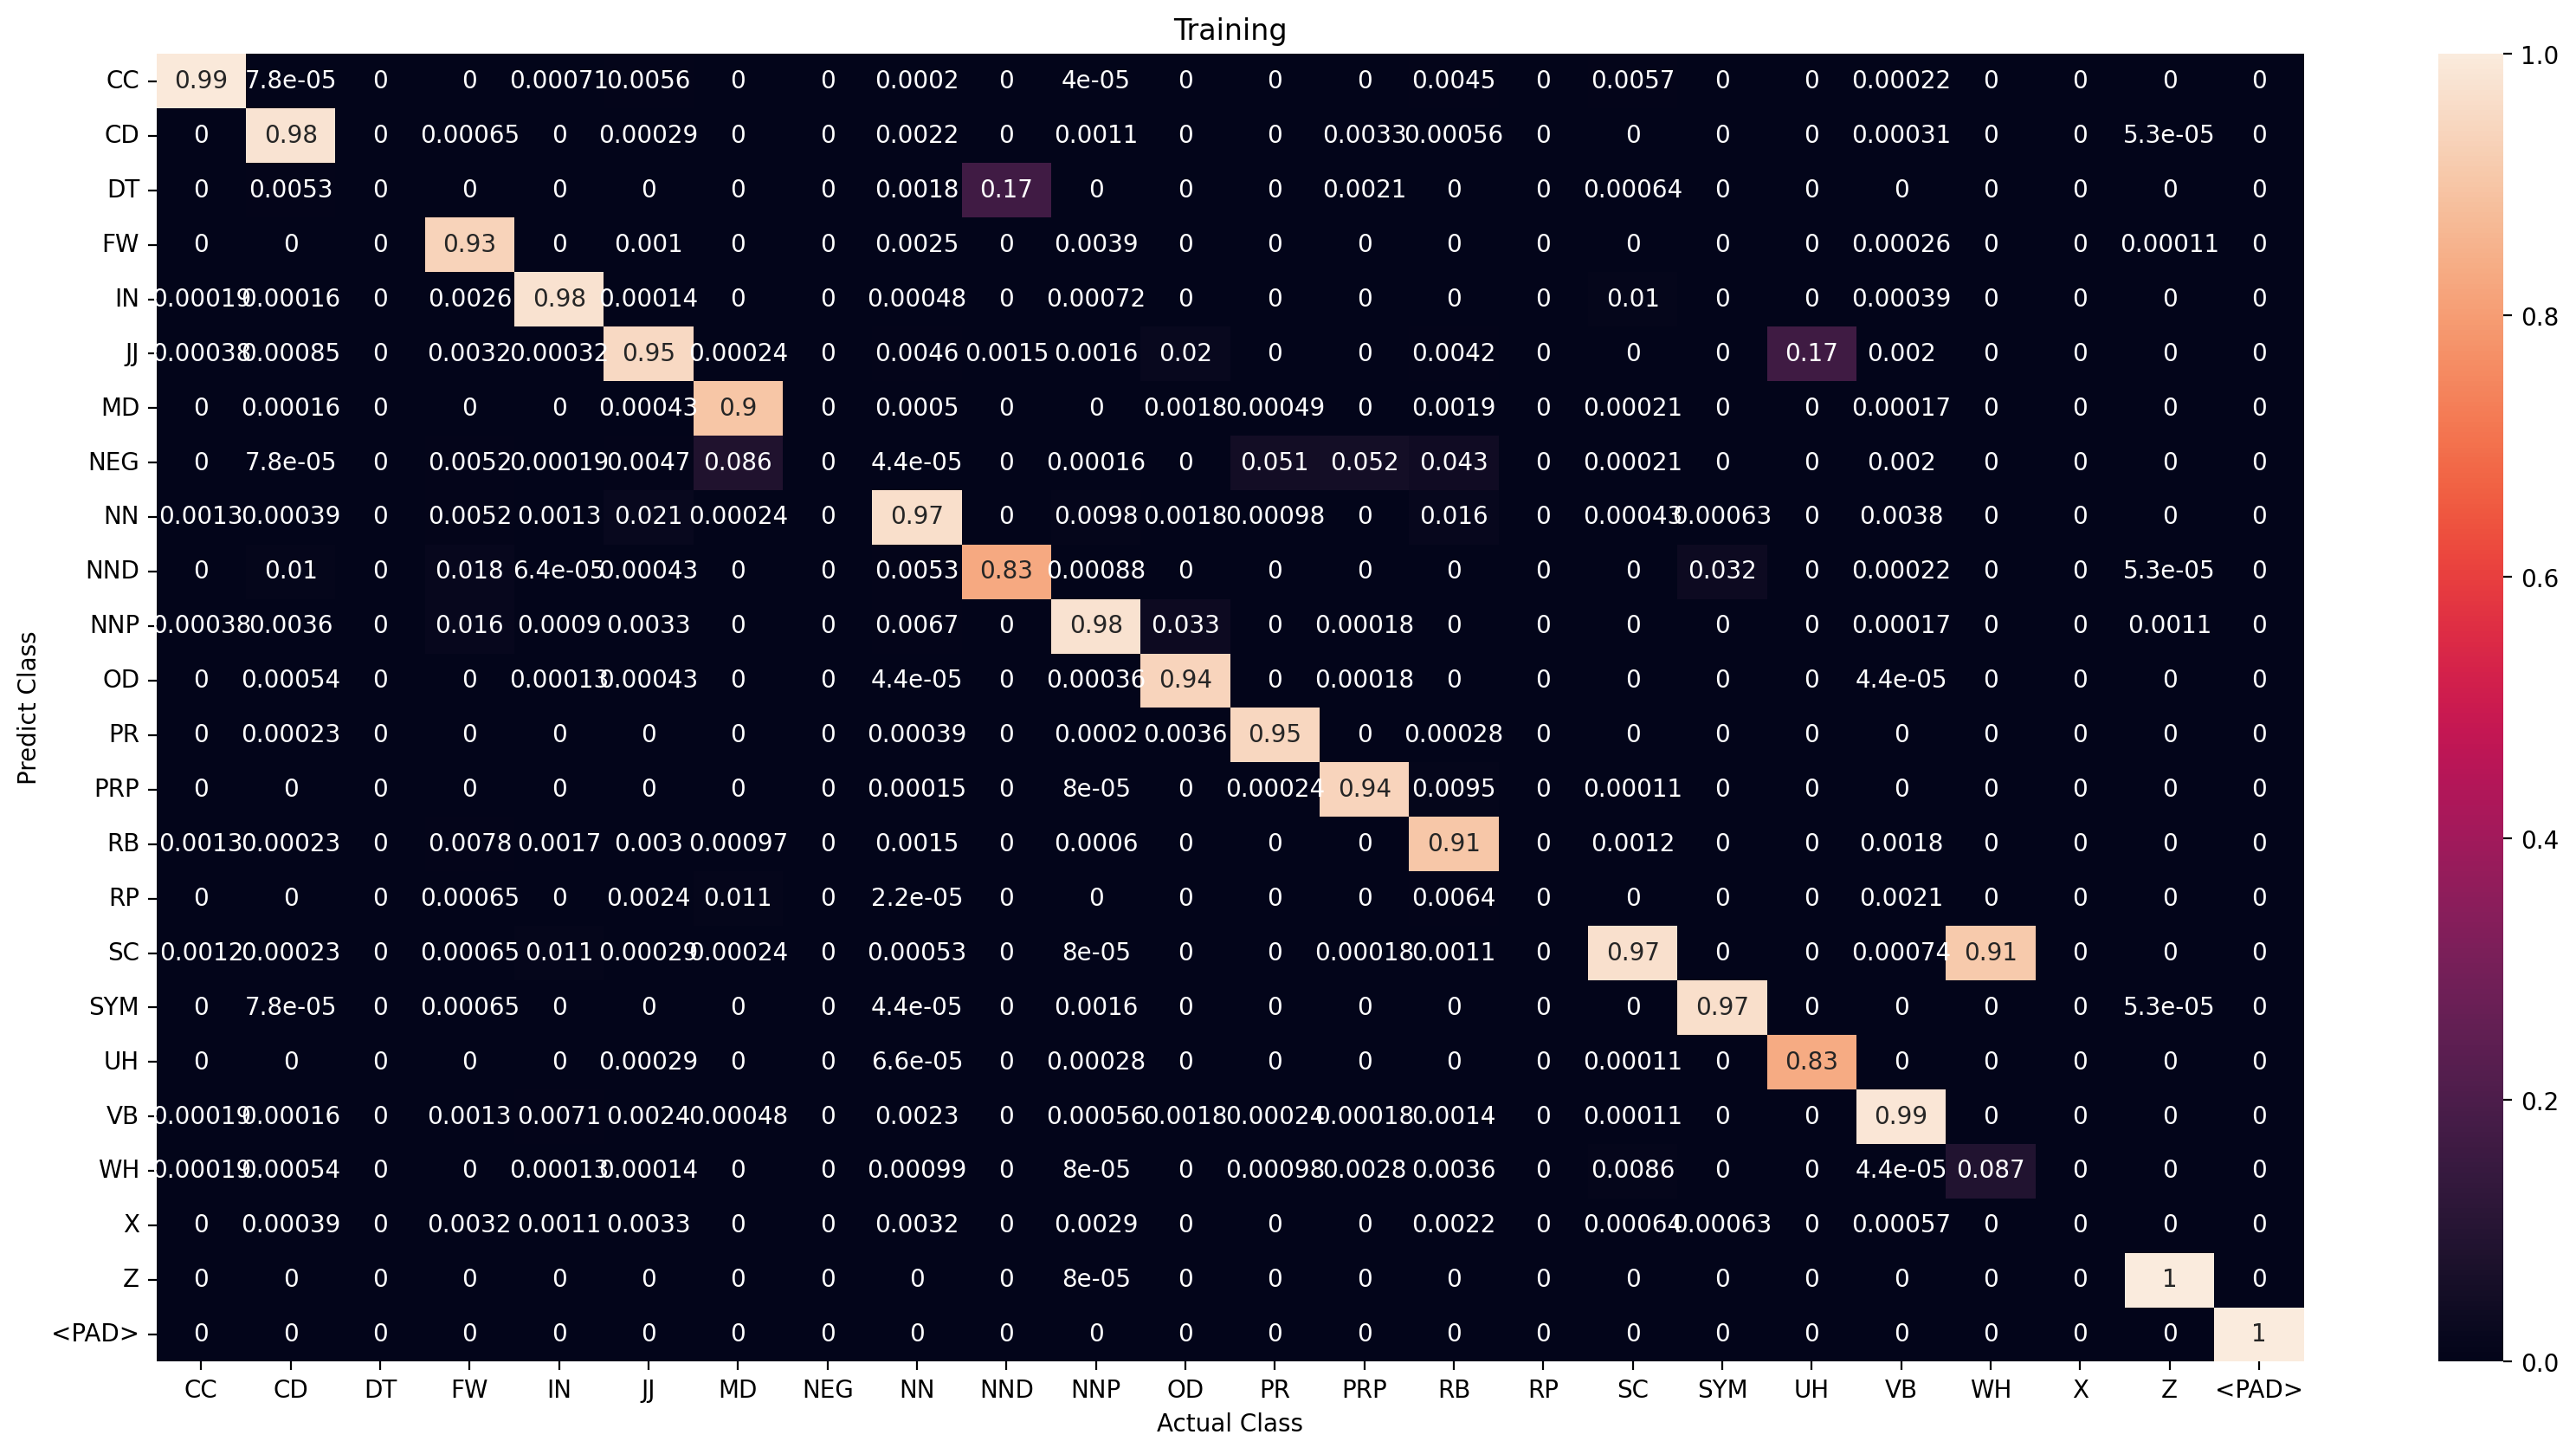

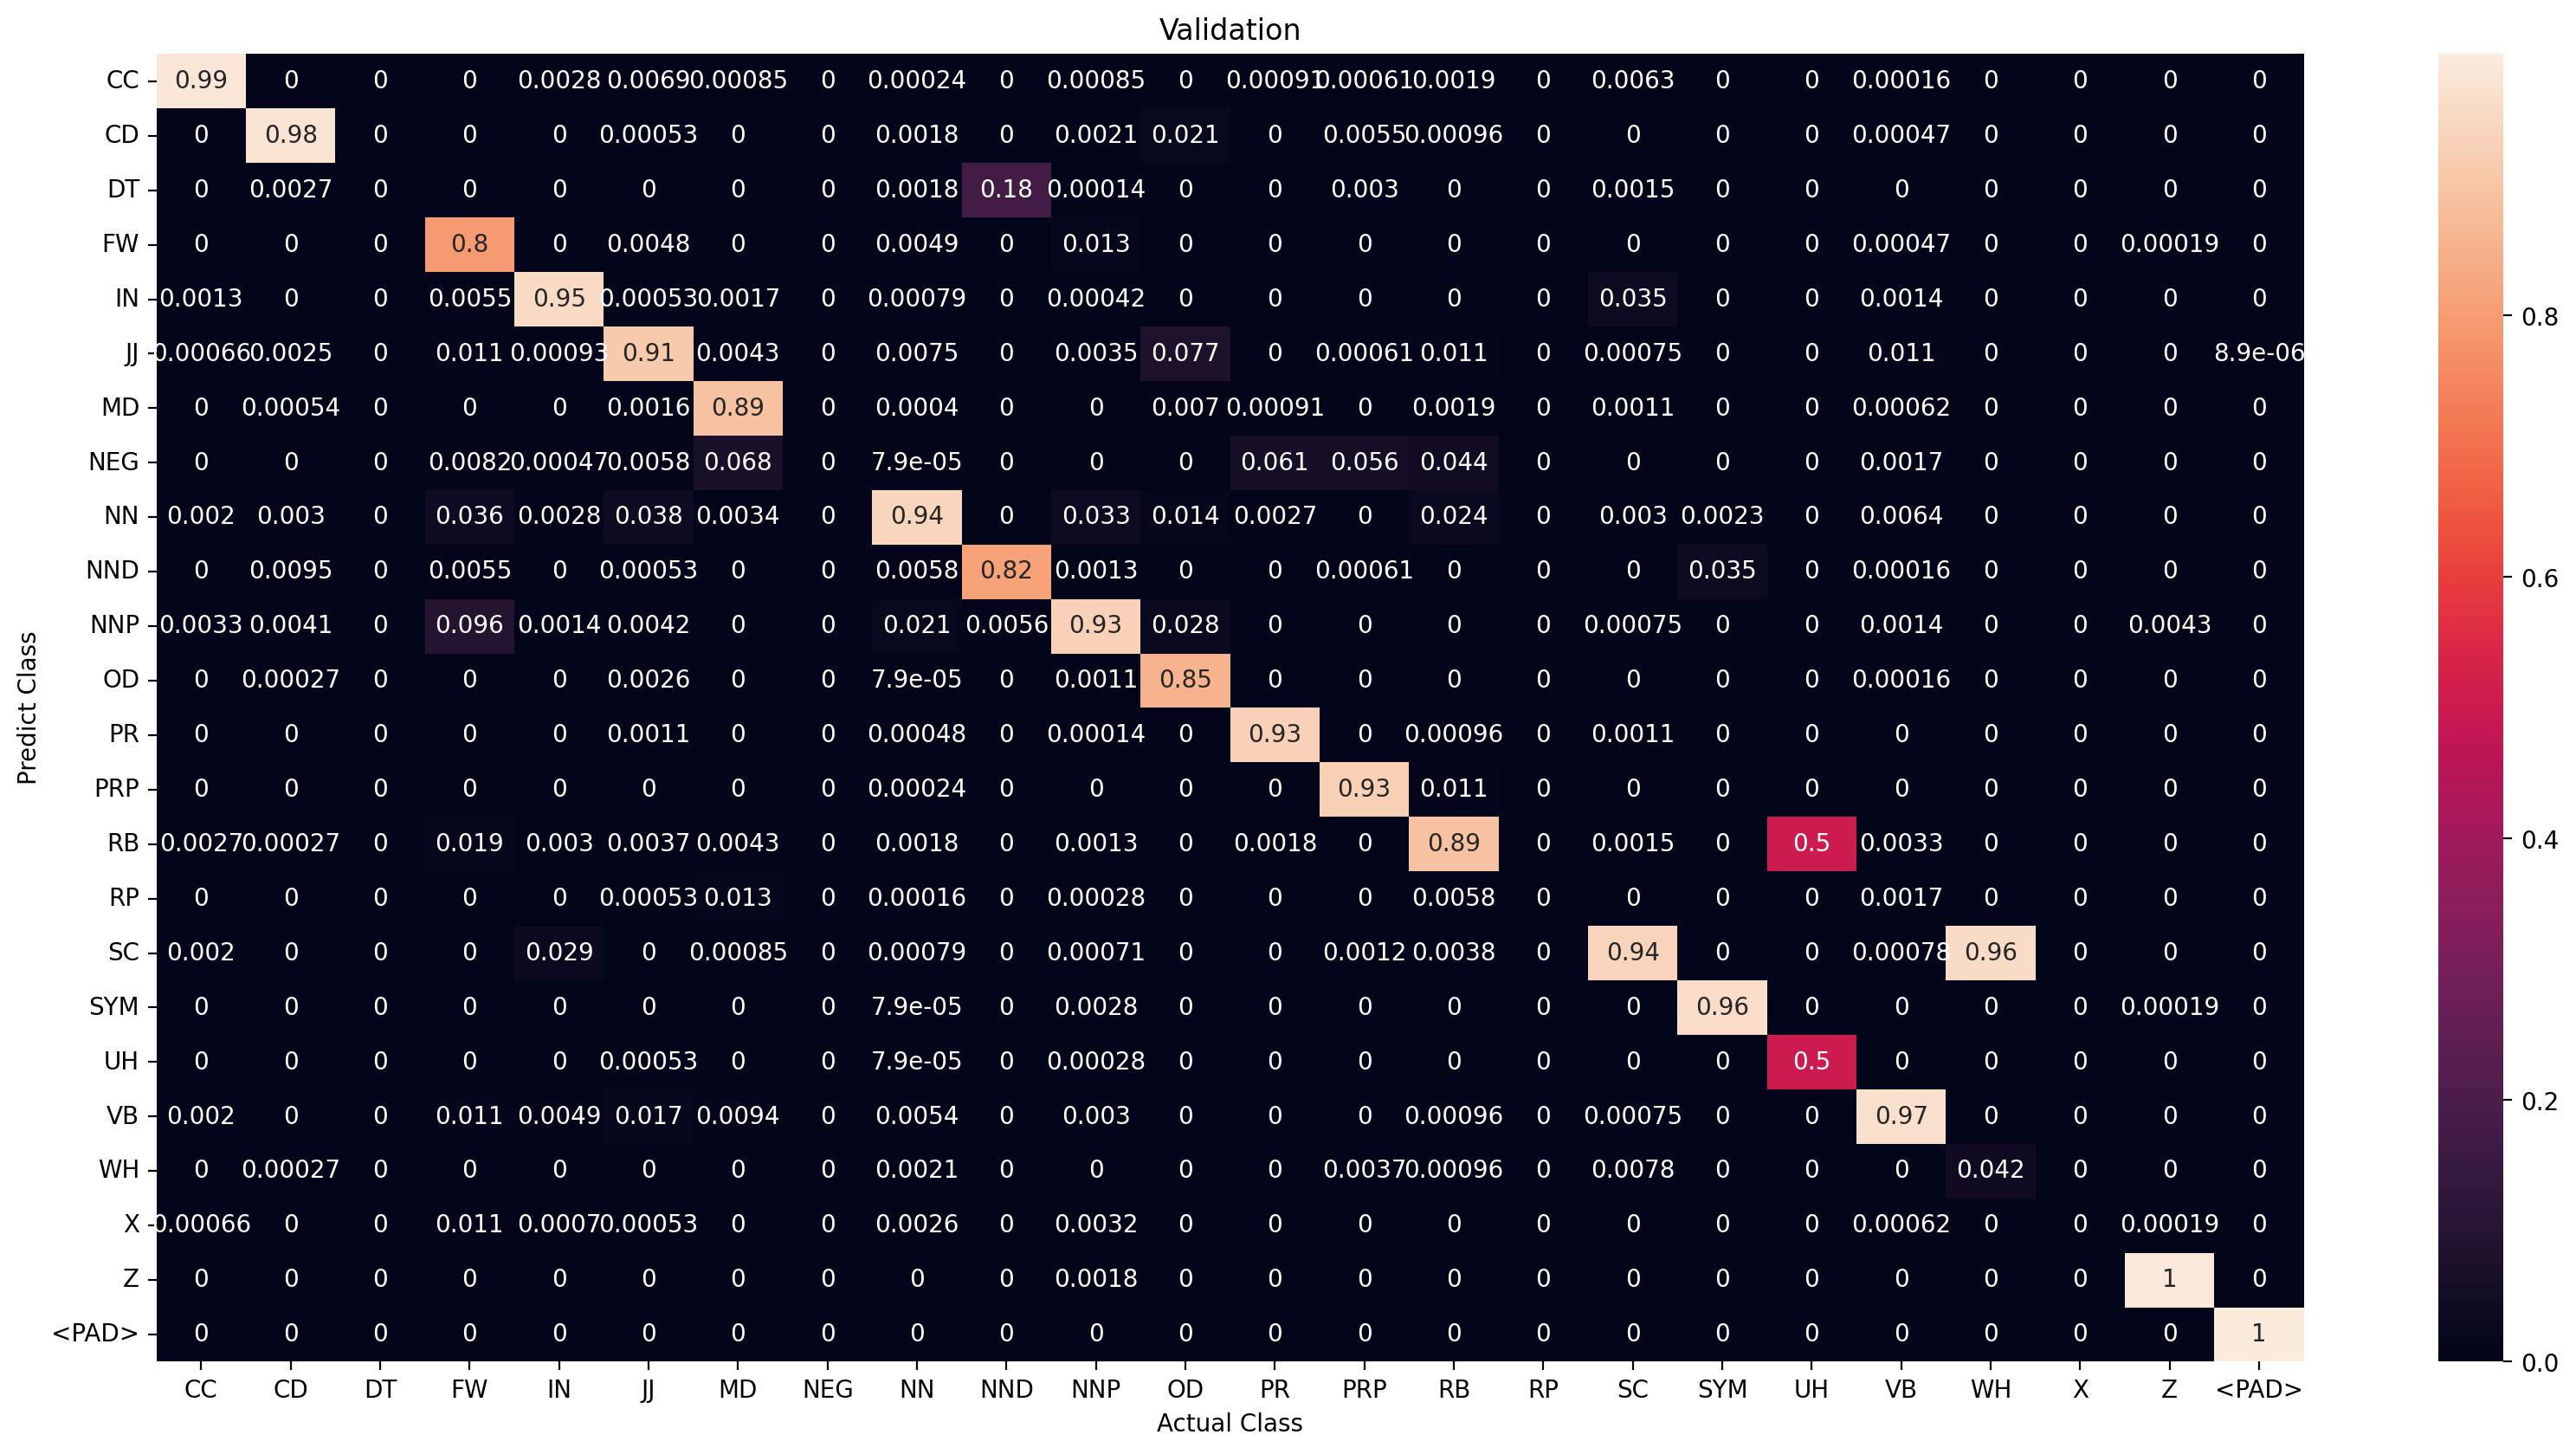

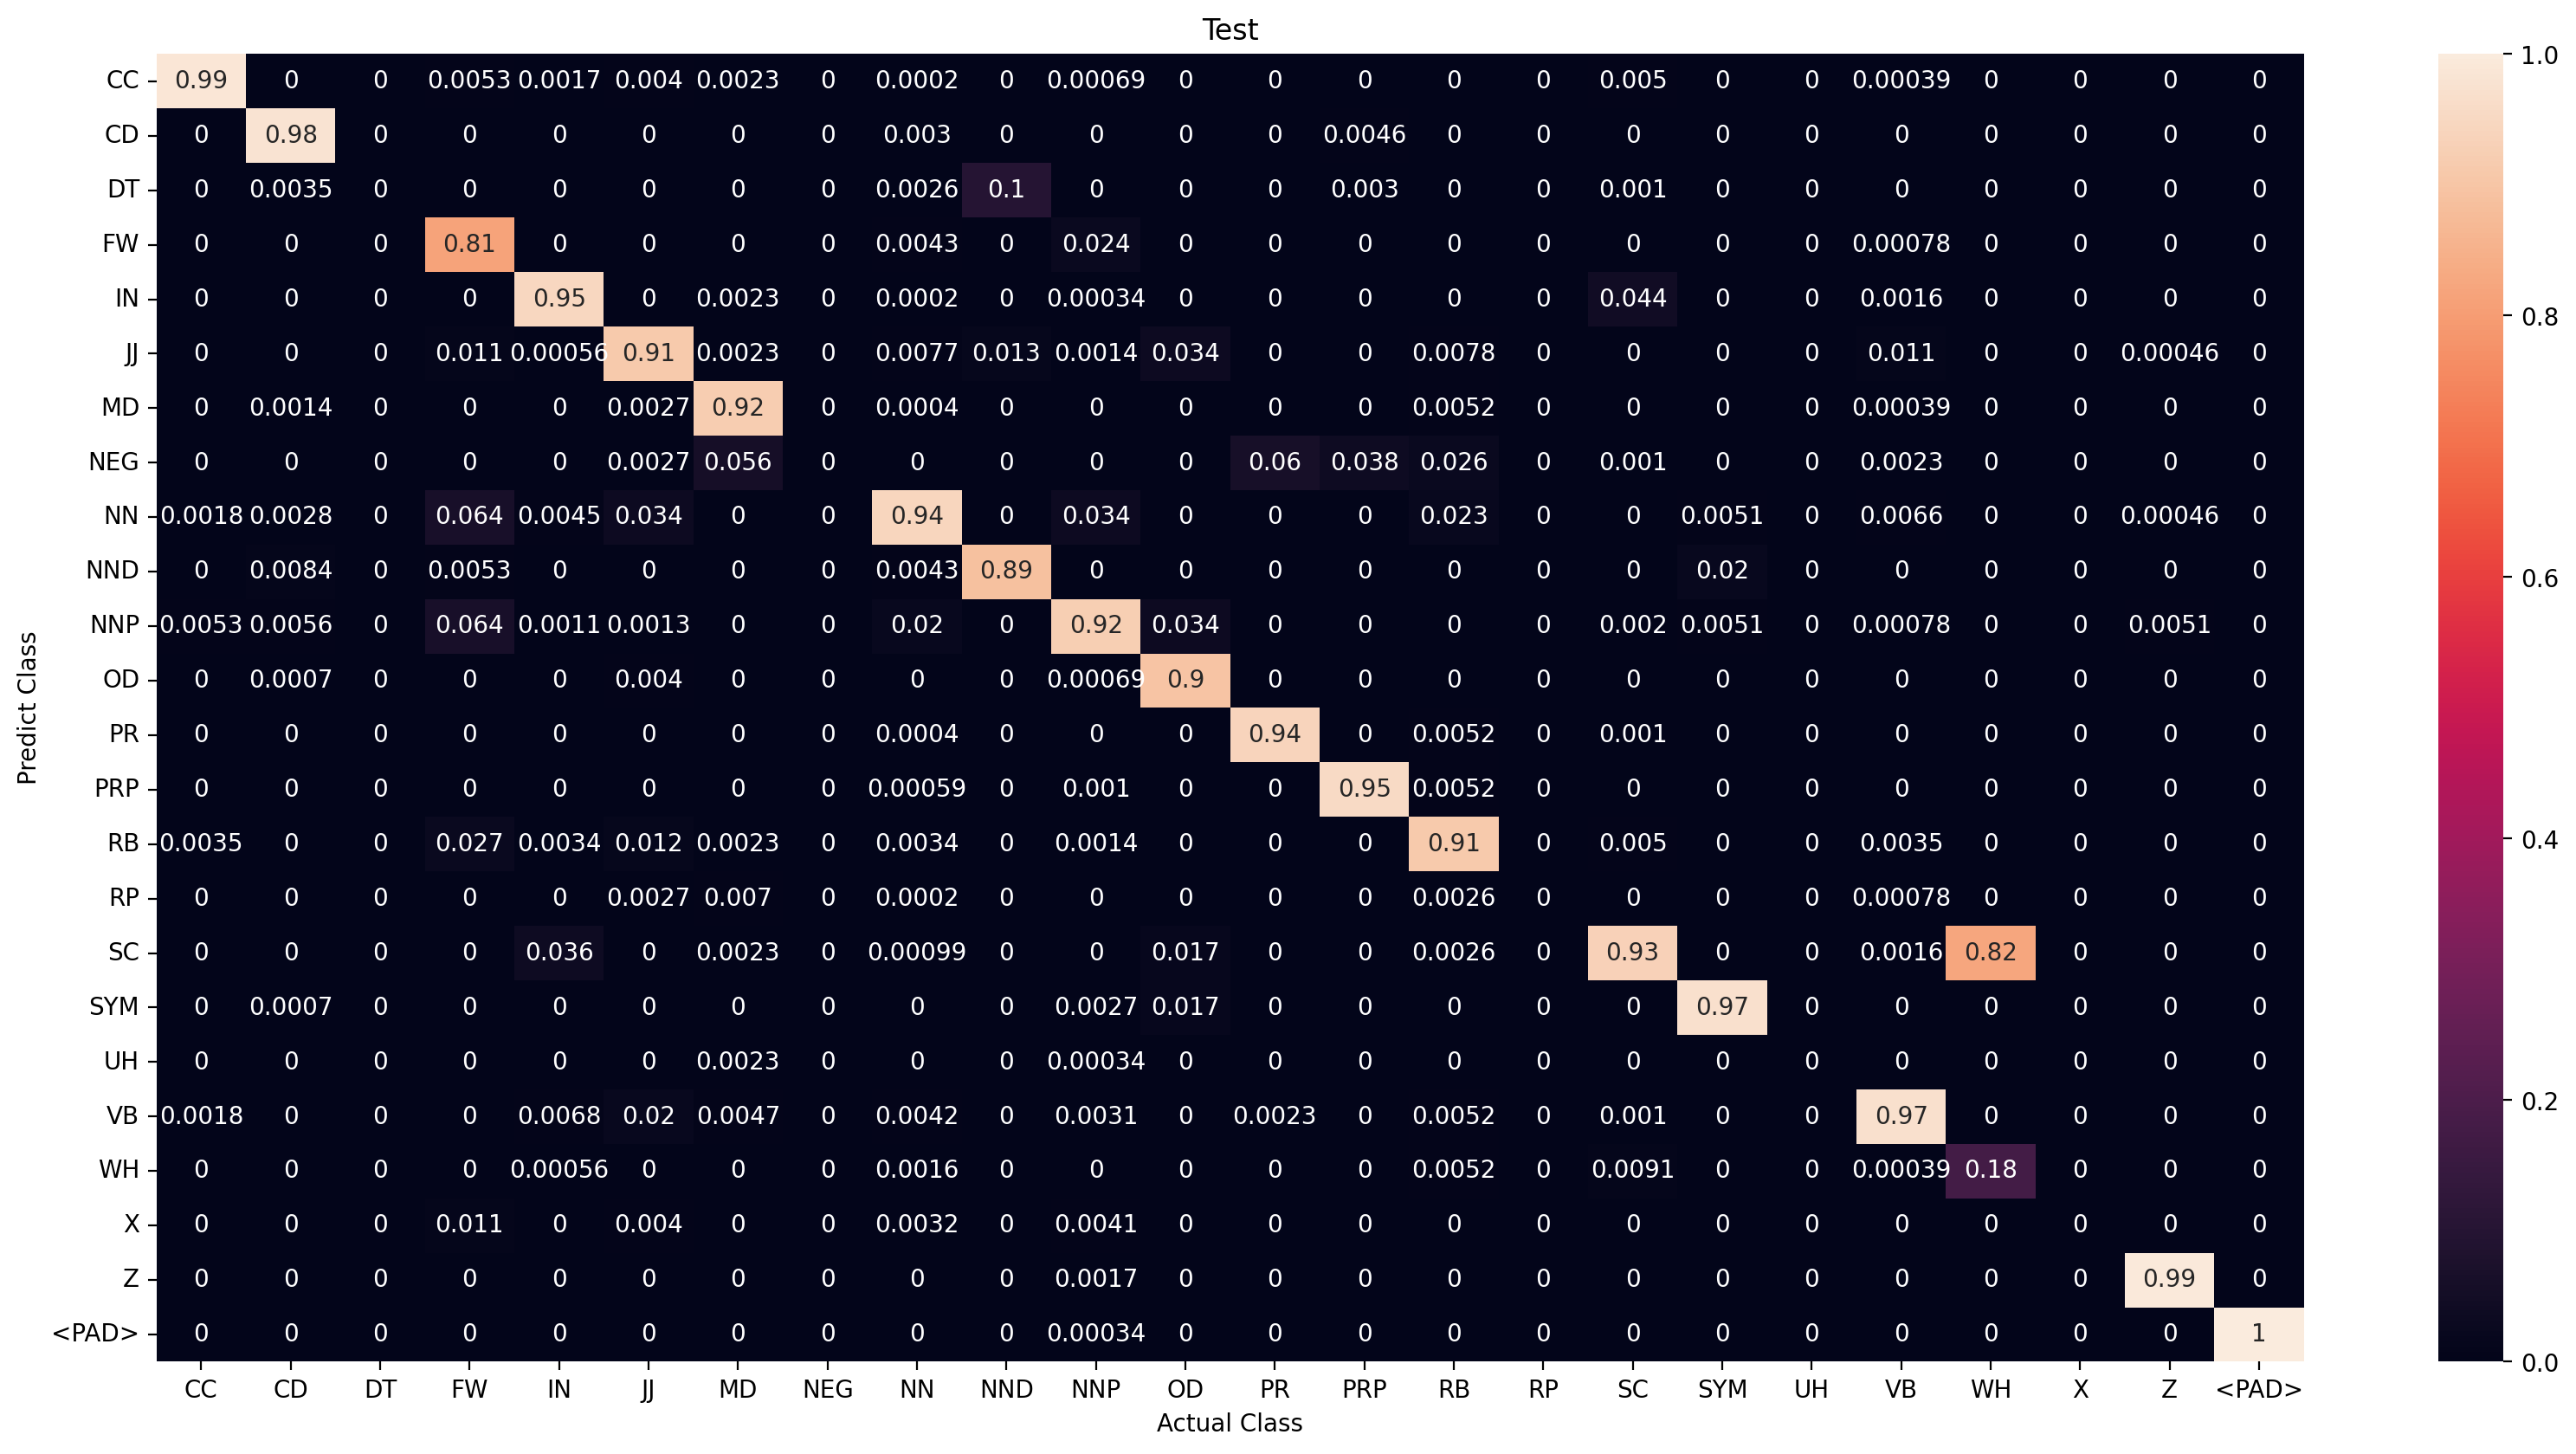

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5322   | CC    : 5187       | CC    : 135      |
| CD    : 12758  | CD    : 12597      | CD    : 161      |
| DT    : 277    | DT    : 0          | DT    : 277      |
| FW    : 1666   | FW    : 1438       | FW    : 228      |
| IN    : 15371  | IN    : 15220      | IN    : 151      |
| JJ    : 6997   | JJ    : 6651       | JJ    : 346      |
| MD    : 3774   | MD    : 3730       | MD    : 44       |
| NEG   : 1113   | NEG   : 0          | NEG   : 1113     |
| NN    : 44672  | NN    : 44081      | NN    : 591      |
| NND   : 1021   | NND   : 536        | NND   : 485      |
| NNP   : 24845  | NNP   : 24384      | NNP   : 461      |
| OD    : 541    | OD    : 516        | OD    : 25       |
| PR    : 3896   | PR    : 3867       | PR    : 29       |
| PRP   : 5408   | PRP   : 5363       | PRP   : 45       |
| RB    : 3463   | RB    : 3253       | RB    : 210      |
| RP    : 137    | RP    : 0          | RP    : 137     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308].detach().cpu() == train_pred_label[308].detach().cpu()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11821
Correct prediction          : 11043
Wrong prediction            : 778
Percentage correct oov pred : 93.41849251332374

Validation
Number OOV token            : 3350
Correct prediction          : 2952
Wrong prediction            : 398
Percentage correct oov pred : 88.11940298507463

Test
Number OOV token            : 1391
Correct prediction          : 1232
Wrong prediction            : 159
Percentage correct oov pred : 88.56937455068297



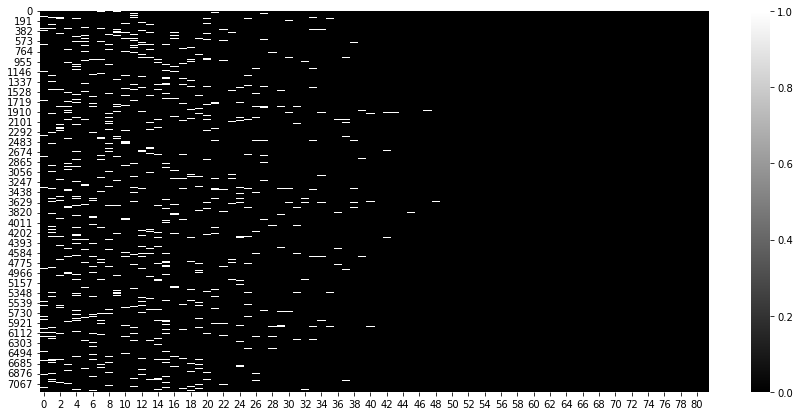

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

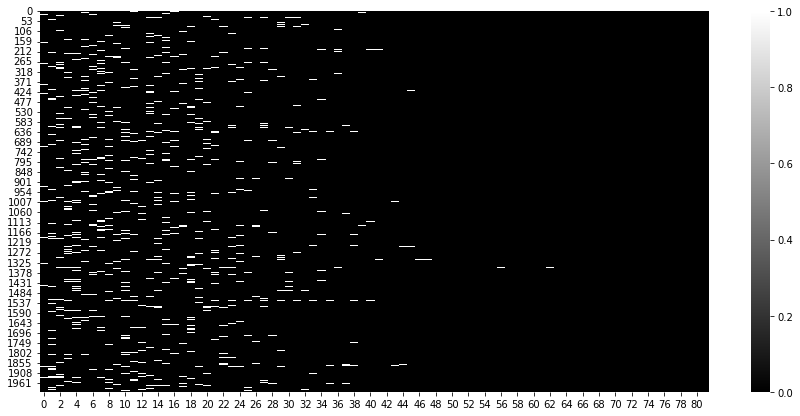

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

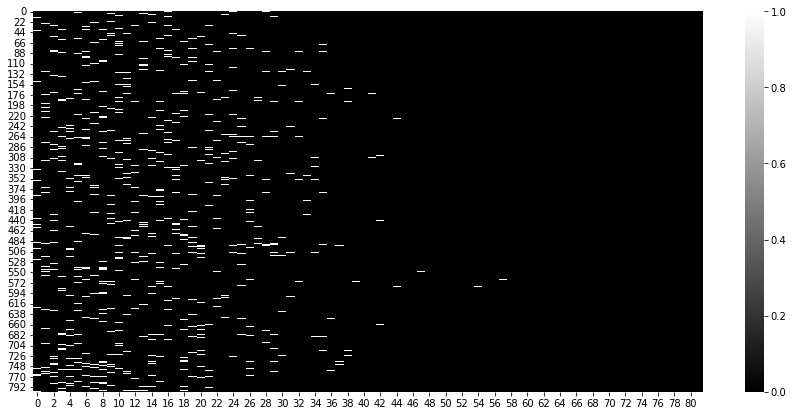

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);